# Project 2: S&P 500 Stocks (daily updated)


---

Code Author: Jose Marin\
Role: Analyst and Data Cleaning\
Organization: St Edwards University\
Class: MATH 3439 INTRODUCTION TO DATA SCIENCE


---

# Our Research Questions
What is the inter-relationship between:


*   Stocks within the same industry (e.g. the relationship in price changes between all tech stocks)
*   Stocks across different industries (e.g. do tech stocks seem to move in a similar fashion to stock in another industry?)

What leading indicators seem to predict movements in stocks?

# Imports

In [54]:
# Imports
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import scipy.cluster.hierarchy as sch

from scipy.spatial.distance import squareform
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, precision_score, recall_score,
                            roc_auc_score, roc_curve)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


# Loading Data


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
drive_dir = '/content/drive/MyDrive/JUNIOR YEAR/Spring Semester/Intro To Data Science/Projects/PROJECT_2'

sp_companies_df = pd.read_csv(drive_dir + '/sp500_companies.csv')
sp_index_df = pd.read_csv(drive_dir + '/sp500_index.csv')
sp_stocks_df = pd.read_csv(drive_dir + '/sp500_stocks.csv')

In [57]:
sp_companies_df.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,229.04,3482347110400,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.064706
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.81,3306889150464,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.061446
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,415.84,3090955370496,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.057433
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,162.08,2001979834368,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037199
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,163.18,2000603054080,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037173


In [58]:
sp_companies_df.shape

(503, 16)

In [59]:
sp_companies_df.dtypes

,0
Exchange,object
Symbol,object
Shortname,object
Longname,object
Sector,object
Industry,object
Currentprice,float64
Marketcap,int64
Ebitda,float64
Revenuegrowth,float64


In [60]:
sp_index_df.head()

,Date,S&P500
0,2014-10-09,1928.21
1,2014-10-10,1906.13
2,2014-10-13,1874.74
3,2014-10-14,1877.70
4,2014-10-15,1862.49


In [61]:
sp_index_df.shape

(2517, 2)

In [62]:
sp_index_df.dtypes

,0
Date,object
S&P500,float64


In [63]:
sp_stocks_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016735,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741009,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361355,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0


In [64]:
sp_stocks_df.shape

(1870154, 8)

In [65]:
sp_stocks_df.dtypes

,0
Date,object
Symbol,object
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,float64


# NaN Values
Checks for Columns with NaN/None values

In [66]:
# Get total number of rows in the DataFrame
total_rows = len(sp_companies_df)

# Checks which columns have NaN values
for col in sp_companies_df.columns:
    if sp_companies_df[col].isna().any():
        sum_nan = sp_companies_df[col].isna().sum()
        percent_nan = (sum_nan / total_rows) * 100  # Calculate percentage
        print(f"Column '{col}' contains {sum_nan} NaN value(s), which is {percent_nan:.2f}% of the sp_companies_df data.")

Column 'Sector' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.
Column 'Industry' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.
Column 'Currentprice' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.
Column 'Ebitda' contains 30 NaN value(s), which is 5.96% of the sp_companies_df data.
Column 'Revenuegrowth' contains 3 NaN value(s), which is 0.60% of the sp_companies_df data.
Column 'City' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.
Column 'State' contains 21 NaN value(s), which is 4.17% of the sp_companies_df data.
Column 'Country' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.
Column 'Fulltimeemployees' contains 6 NaN value(s), which is 1.19% of the sp_companies_df data.
Column 'Longbusinesssummary' contains 1 NaN value(s), which is 0.20% of the sp_companies_df data.


In [67]:
# Get total number of rows in the DataFrame
total_rows = len(sp_index_df)

# Checks which columns have NaN values
for col in sp_index_df.columns:
    if sp_index_df[col].isna().any():
        sum_nan = sp_index_df[col].isna().sum()
        percent_nan = (sum_nan / total_rows) * 100  # Calculate percentage
        print(f"Column '{col}' contains {sum_nan} NaN value(s), which is {percent_nan:.2f}% of the sp_index_df data.")

In [68]:
# Get total number of rows in the DataFrame
total_rows = len(sp_stocks_df)

# Checks which columns have NaN values
for col in sp_stocks_df.columns:
    if sp_stocks_df[col].isna().any():
        sum_nan = sp_stocks_df[col].isna().sum()
        percent_nan = (sum_nan / total_rows) * 100  # Calculate percentage
        print(f"Column '{col}' contains {sum_nan} NaN value(s), which is {percent_nan:.2f}% of the sp_stocks_df data.")

Column 'Adj Close' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.
Column 'Close' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.
Column 'High' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.
Column 'Low' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.
Column 'Open' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.
Column 'Volume' contains 101626 NaN value(s), which is 5.43% of the sp_stocks_df data.


# Data Cleaning

*   Converting datatypes
*   Dropping NaN/None values
*   Dropping unnecessary Columns
*   Renaming Columns for clarity





In [69]:
# Converting Datatypes

# Changing sp_index_df 'Date' Column to Datetime dtype
sp_index_df['Date'] = pd.to_datetime(sp_index_df['Date'])
# Changing sp_stocks_df 'Date' Column to Datetime dtype
sp_stocks_df['Date'] = pd.to_datetime(sp_stocks_df['Date'])

In [70]:
# Dropping NaN Values
sp_companies_df = sp_companies_df.dropna()
sp_index_df = sp_index_df.dropna()
sp_stocks_df = sp_stocks_df.dropna()

In [71]:
# Sanity Check
assert sp_companies_df.isna().sum().max() == 0
assert sp_index_df.isna().sum().max() == 0
assert sp_stocks_df.isna().sum().max() == 0

In [72]:
# Renamening and Droping unnecessary columns
sp_companies_df.drop(columns=["Shortname"], inplace=True)
sp_companies_df.drop(columns=['Longbusinesssummary'], inplace=True)
sp_companies_df.rename(columns={"Longname": "Companyname"}, inplace=True)

# Merging Data

**Merging sp_companies_df 'Sector' column with sp_stocks_df**

Goal: Attach company details (sector and Symbol.) to the stock price data.

*   Key Column for Merge: Symbol (Ticker symbol)
*   Merge Type: Left Join
*   Reason: We want all stock price data (sp_stocks_df), and only relevant company information should be added. If a company is missing, its stock data should still be kept.

In [73]:
# Extract only 'Symbol' and 'Sector' from sp_companies_df
sector_data = sp_companies_df[['Symbol', 'Sector']]

# Merge 'Sector' into sp_stocks_df based on 'Symbol' (left join to keep all stock data)
final_df = sp_stocks_df.merge(sector_data, on="Symbol", how="left")

In [74]:
# Get total number of rows in the DataFrame
total_rows = len(final_df)

# Checks which columns have NaN values
for col in final_df.columns:
    if final_df[col].isna().any():
        sum_nan = final_df[col].isna().sum()
        percent_nan = (sum_nan / total_rows) * 100  # Calculate percentage
        print(f"Column '{col}' contains {sum_nan} NaN value(s), which is {percent_nan:.2f}% of the final_df data.")

Column 'Sector' contains 188884 NaN value(s), which is 10.68% of the final_df data.


In [75]:
final_df['Sector'].unique()

array(['Industrials', 'Healthcare', nan, 'Technology', 'Utilities',
       'Financial Services', 'Basic Materials', 'Consumer Cyclical',
       'Real Estate', 'Communication Services', 'Consumer Defensive',
       'Energy'], dtype=object)

In [76]:
# Find symbols that exist in sp_stocks_df but not in sp_companies_df
stocks_symbols = set(sp_stocks_df["Symbol"].unique())
companies_symbols = set(sp_companies_df["Symbol"].unique())

# Symbols present in stocks but missing from companies
missing_in_companies = stocks_symbols - companies_symbols

# Symbols present in companies but missing from stocks
missing_in_stocks = companies_symbols - stocks_symbols

# Create a summary report
missing_symbols_summary = {
    "Missing in Companies (Exists in Stocks)": list(missing_in_companies),
    "Missing in Stocks (Exists in Companies)": list(missing_in_stocks),
}

print(missing_symbols_summary)

{'Missing in Companies (Exists in Stocks)': ['KKR', 'SCHW', 'C', 'WRB', 'RF', 'COF', 'DFS', 'AMP', 'STT', 'MDT', 'AON', 'BX', 'APTV', 'MTB', 'TFC', 'AZO', 'SMCI', 'LIN', 'CB', 'SW', 'TT', 'NTRS', 'ETN', 'WFC', 'WTW', 'JCI', 'NXPI', 'GS', 'AMCR', 'FITB', 'SOLV', 'USB', 'AMTM', 'RJF', 'TEL', 'ALLE', 'JBL', 'PNR', 'MS', 'ACGL', 'CFG', 'V', 'SYF', 'JPM', 'BAC', 'WDC', 'ACN', 'EG', 'AXP', 'GRMN', 'HBAN', 'STX', 'BK', 'KEY', 'PNC'], 'Missing in Stocks (Exists in Companies)': []}


In [77]:
# Manually assign correct sectors to missing symbols based on the provided list
manual_sector_assignments = {
    "HBAN": "Financial Services",
    "TFC": "Financial Services",
    "AON": "Financial Services",
    "MTB": "Financial Services",
    "ALLE": "Industrials",
    "SYF": "Financial Services",
    "BK": "Financial Services",
    "CB": "Financial Services",
    "AMP": "Financial Services",
    "MS": "Financial Services",
    "CFG": "Financial Services",
    "JPM": "Financial Services",
    "EG": "Financial Services",
    "PNC": "Financial Services",
    "WTW": "Financial Services",
    "DFS": "Financial Services",
    "WFC": "Financial Services",
    "SMCI": "Technology",
    "APTV": "Consumer Cyclical",
    "RF": "Financial Services",
    "JBL": "Technology",
    "COF": "Financial Services",
    "WDC": "Technology",
    "C": "Financial Services",
    "WRB": "Financial Services",
    "V": "Financial Services",
    "GS": "Financial Services",
    "AMTM": "Industrials",
    "AMCR": "Basic Materials",
    "NXPI": "Technology",
    "ACN": "Technology",
    "STX": "Technology",
    "KEY": "Financial Services",
    "TEL": "Technology",
    "USB": "Financial Services",
    "KKR": "Financial Services",
    "NTRS": "Financial Services",
    "STT": "Financial Services",
    "JCI": "Industrials",
    "ETN": "Industrials",
    "TT": "Industrials",
    "BAC": "Financial Services",
    "AXP": "Financial Services",
    "FITB": "Financial Services",
    "SCHW": "Financial Services",
    "SOLV": "Healthcare",
    "GRMN": "Technology",
    "MDT": "Healthcare",
    "BX": "Financial Services",
    "RJF": "Financial Services",
    "ACGL": "Financial Services",
    "SW": "Industrials",
    "AZO": "Consumer Cyclical",
    "LIN": "Basic Materials",
    "PNR": "Industrials"
}

# Update the missing sectors in sp_stocks_df using the manual assignments
final_df["Sector"] = final_df["Sector"].fillna(final_df["Symbol"].map(manual_sector_assignments))

# Verify that no missing sector values remain
missing_sectors_after_fix = final_df["Sector"].isna().sum()
missing_sectors_after_fix

0

In [78]:
final_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Sector
0,2010-01-04,MMM,44.016735,69.414719,69.774246,69.122070,69.473244,3640265.0,Industrials
1,2010-01-05,MMM,43.741009,68.979935,69.590302,68.311035,69.230766,3405012.0,Industrials
2,2010-01-06,MMM,44.361355,69.958191,70.735786,69.824417,70.133781,6301126.0,Industrials
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0,Industrials
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0,Industrials


In [79]:
assert final_df.isna().sum().max() == 0

# Downloading Clean Data

*Uncomment Code to download data**

In [107]:
# After running the code, the CSV file will be available in the Colab environment's file explorer (left sidebar). # Click the three dots next to the file name and select "Download" to save it to your local machine.
#
#
#
# Uncomment Code to download data*
#
#
#
#
# final_df.to_csv('cleaned_data.csv', index=False)

# Stocks across different industries (e.g. do tech stocks seem to move in a similar fashion to stock in another industry?)

**"Do stocks across different industries move in a similar fashion?"**

*Here are the next steps we can take:*

*   Correlation Heatmap – Shows how industries move together.
*   Industry Time Series Plot – Overlays sector price movements.
*   Cross-Correlation Plot – Detects leading & lagging industry trends.
*   Pairwise Scatterplots – Visualizes relationships between industry returns.
*   Clustering Dendrogram – Groups industries with similar return behaviors.
*   PCA (Principal Component Analysis) Plot – Identifies major market trends.

In [81]:
final_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Sector
0,2010-01-04,MMM,44.016735,69.414719,69.774246,69.122070,69.473244,3640265.0,Industrials
1,2010-01-05,MMM,43.741009,68.979935,69.590302,68.311035,69.230766,3405012.0,Industrials
2,2010-01-06,MMM,44.361355,69.958191,70.735786,69.824417,70.133781,6301126.0,Industrials
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0,Industrials
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0,Industrials


In [82]:
final_df['Sector'].unique()

array(['Industrials', 'Healthcare', 'Technology', 'Utilities',
       'Financial Services', 'Basic Materials', 'Consumer Cyclical',
       'Real Estate', 'Communication Services', 'Consumer Defensive',
       'Energy'], dtype=object)

**📊 Correlation Heatmap – Shows how industries move together.**

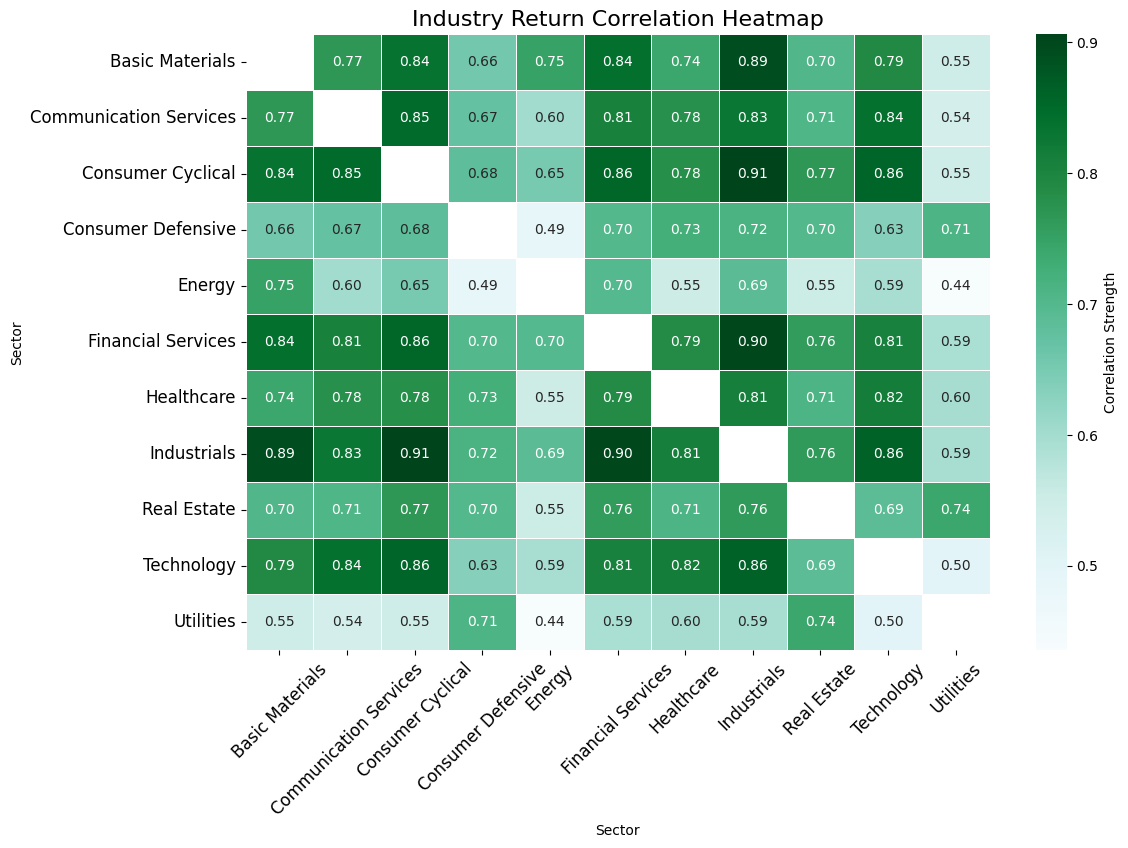

In [83]:
# Compute daily percentage change in adjusted closing prices
final_df["Daily Return"] = final_df.groupby("Symbol")["Adj Close"].pct_change()

# Aggregate to industry level by taking the mean of all stock returns in each industry per day
industry_returns = final_df.groupby(["Date", "Sector"])["Daily Return"].mean().unstack()

# Compute correlation matrix of industry returns
industry_correlation = industry_returns.corr()

# Mask the diagonal by setting it to NaN
mask = np.eye(industry_correlation.shape[0], dtype=bool)

# Create heatmap with strong color contrast
plt.figure(figsize=(12, 8), facecolor='none')
sns.heatmap(
    industry_correlation,
    annot=True,
    cmap="BuGn",
    linewidths=0.5,
    fmt=".2f",
    mask=mask,
    cbar_kws={"label": "Correlation Strength"}  # Color bar label
)

# Adjust titles and labels
plt.title("Industry Return Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.gca().set_facecolor('none')

# Show the plot
plt.show()

**Strongest Correlations (0.80+)**

*   📈 Industrials & Consumer Cyclical (0.91): These sectors move almost in sync, likely due to shared economic drivers such as business cycles and consumer demand.
*   💳 Financial Services & Consumer Cyclical (0.86): Indicates that financial conditions directly impact consumer spending patterns.
*   💻 Technology & Communication Services (0.84): Suggests strong interdependence, possibly due to tech advancements driving digital communication.

**Moderate Correlations (0.60 - 0.80)**

*   🏥 Healthcare & Financial Services (0.79): May reflect the financial sector’s role in healthcare funding and insurance.
*   🏗️ Basic Materials & Industrials (0.89): Expected, as industrial growth is closely tied to material demand.

**Weakest Correlations (0.40 - 0.60)**

*   ⛽ Energy & Utilities (0.44): Despite both being resource sectors, energy prices tend to be more volatile, while utilities are defensive stocks.
*   ⚡ Utilities & Technology (0.50): Shows little relationship—tech stocks thrive on innovation, whereas utilities are driven by regulation and stability.

**📈 Industry Time Series Plot – Overlays sector price movements.**

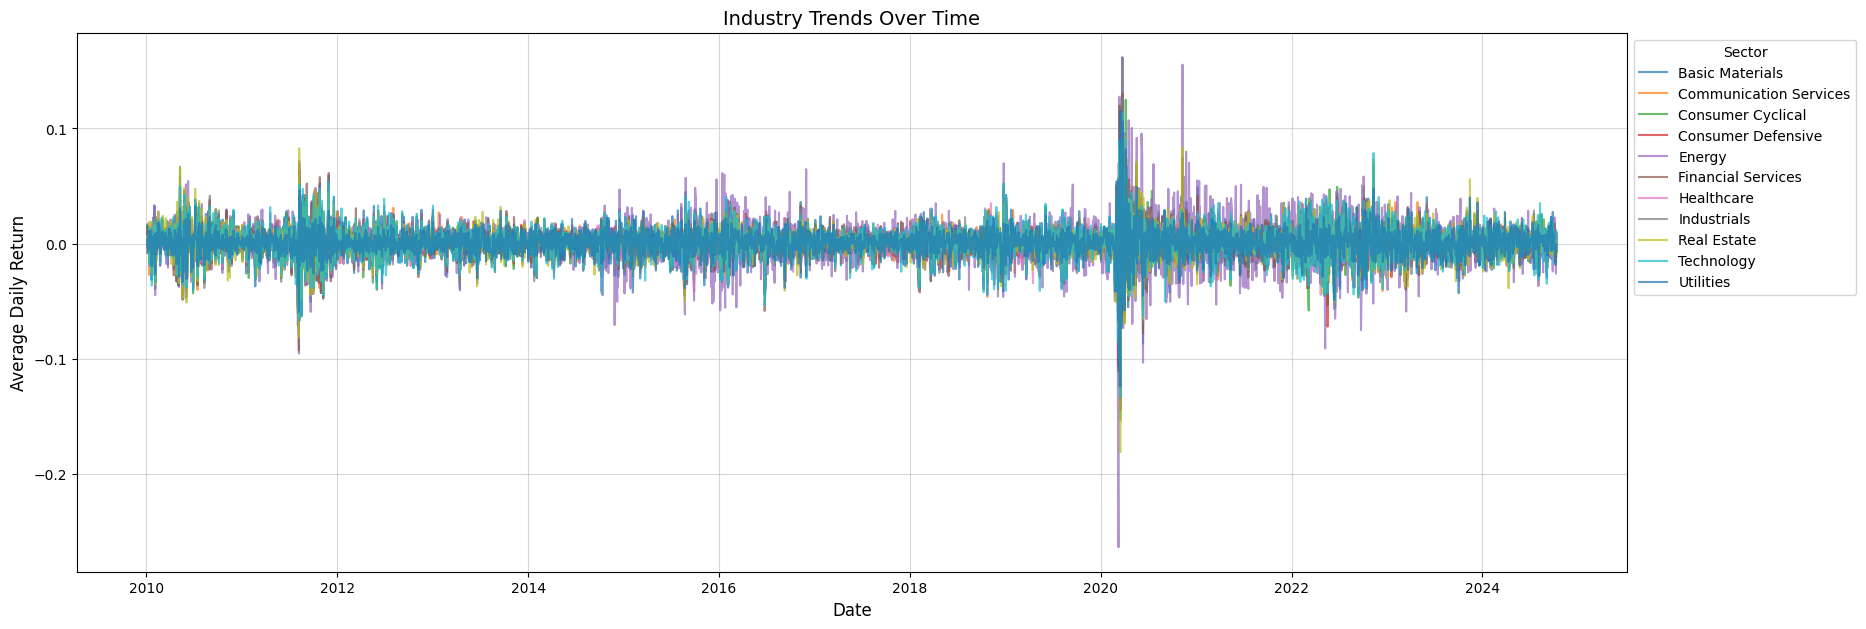

In [84]:
# Aggregate daily returns by sector
sector_returns = final_df.groupby(["Date", "Sector"])["Daily Return"].mean().unstack()

# Create figure with transparent background
plt.figure(figsize=(20, 7), facecolor='none')  # Transparent figure background

# Plot sector trends over time
for sector in sector_returns.columns:
    plt.plot(sector_returns.index, sector_returns[sector], label=sector, alpha=0.7)

# Set plot properties
plt.title("Industry Trends Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Daily Return", fontsize=12)
plt.legend(title="Sector", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, alpha=0.5)  # Grid with transparency
plt.gca().set_facecolor('none')  # Transparent axes background

# Show the plot
plt.show()

In [85]:
final_df[['Symbol','Adj Close','Daily Return']].head()

,Symbol,Adj Close,Daily Return
0,MMM,44.016735,NaN
1,MMM,43.741009,-0.006264
2,MMM,44.361355,0.014182
3,MMM,44.393166,0.000717
4,MMM,44.705990,0.007047


In [86]:
sector_returns.head()

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
Date,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000823,0.002500,0.015408,0.001537,0.007164,0.008594,-0.002748,0.005067,0.005565,-0.000990,-0.008185
2010-01-06,0.017045,-0.007714,-0.001316,0.006978,0.013389,0.000864,0.002094,0.007173,-0.001763,-0.001183,0.004040
2010-01-07,-0.003449,-0.005609,0.015333,-0.000553,-0.002605,0.015128,0.007337,0.008077,0.006461,-0.001803,-0.003917
2010-01-08,0.006786,-0.000786,0.002815,-0.004167,0.006481,0.000795,-0.000710,0.008633,-0.006151,0.007696,-0.000061


**Volatility Spikes in 2020 📉📈**

*   There is a major drop and spike around 2020, likely due to the COVID-19 market crash and recovery.
*   This shows that almost all industries were affected, but to different extents.

**Industries Move Together but with Variability**

*   Some industries appear to have more extreme movements than others.
*   Technology, Financial Services, and Consumer Cyclical sectors tend to have larger fluctuations.
*   Utilities and Consumer Defensive sectors appear to be more stable, which aligns with their defensive nature.

**Patterns in Business Cycles**

*   Market-wide trends like 2008 Recession, 2011 Euro Crisis, and 2020 COVID-19 Crash can be seen.
*   Some industries lead the market, while others follow trends with a delay.






**📉 Cross-Correlation Plot – Detects leading & lagging industry trends.**

<Figure size 1200x600 with 0 Axes>

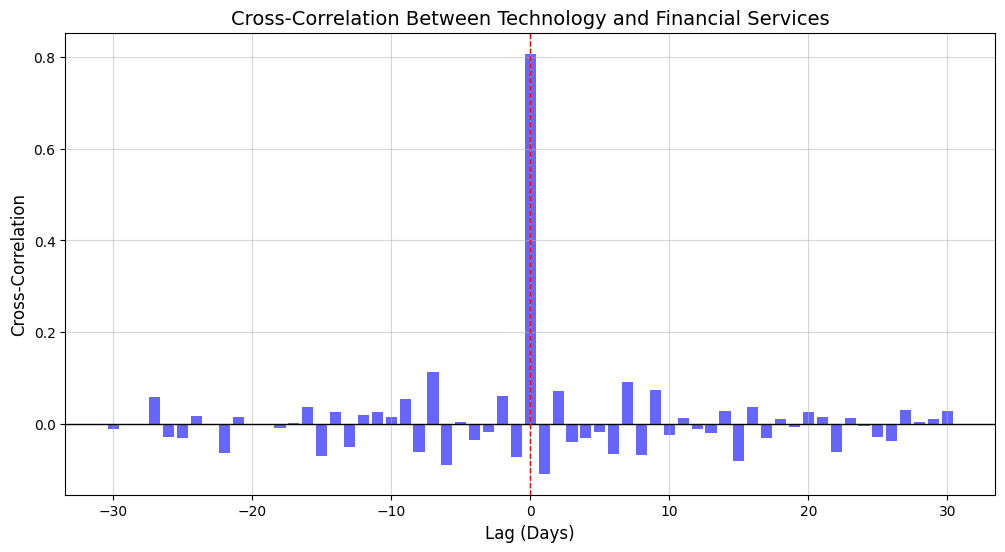

In [87]:
# Selecting two example sectors to analyze cross-correlation
sector_1 = "Technology"
sector_2 = "Financial Services"

# Extract time series data for the selected sectors
sector_1_returns = sector_returns[sector_1].dropna()
sector_2_returns = sector_returns[sector_2].dropna()

# Align both series to have the same dates
common_dates = sector_1_returns.index.intersection(sector_2_returns.index)
sector_1_returns = sector_1_returns.loc[common_dates]
sector_2_returns = sector_2_returns.loc[common_dates]

# Compute cross-correlation
max_lag = 30  # Number of days to check for leading/lagging effects
cross_correlation = [sector_1_returns.corr(sector_2_returns.shift(lag)) for lag in range(-max_lag, max_lag + 1)]

# Create figure with transparent background
plt.figure(figsize=(12, 6), facecolor='none')

# Plot cross-correlation
lags = np.arange(-max_lag, max_lag + 1)
plt.figure(figsize=(12, 6))
plt.bar(lags, cross_correlation, color="b", alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='red', linestyle="--", linewidth=1)  # Mark lag=0
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title(f"Cross-Correlation Between {sector_1} and {sector_2}", fontsize=14)
plt.grid(True, alpha=0.5)  # Grid with transparency
plt.gca().set_facecolor('none')  # Transparent axes background

# Show the plot
plt.show()

**Strongest correlation at lag = 0 📍**

*   The highest cross-correlation occurs at lag = 0, meaning Technology and Financial Services tend to move together on the same day.
*   This suggests that these sectors react simultaneously to market changes.

**Low correlation at nonzero lags**

*   There are no significant correlations at positive or negative lags.
*   This indicates that neither Technology leads Financial Services nor Financial Services leads Technology over the given time frame.

**Possible Interpretation**

*   Both sectors are highly influenced by macroeconomic factors (interest rates, economic growth, Fed decisions, etc.), causing them to move together rather than one leading the other.
*   This suggests that investors react simultaneously to financial news affecting both industries.

**🔍 Next Cross-Correlation Analysis: Does Technology Affect Other Sectors?**

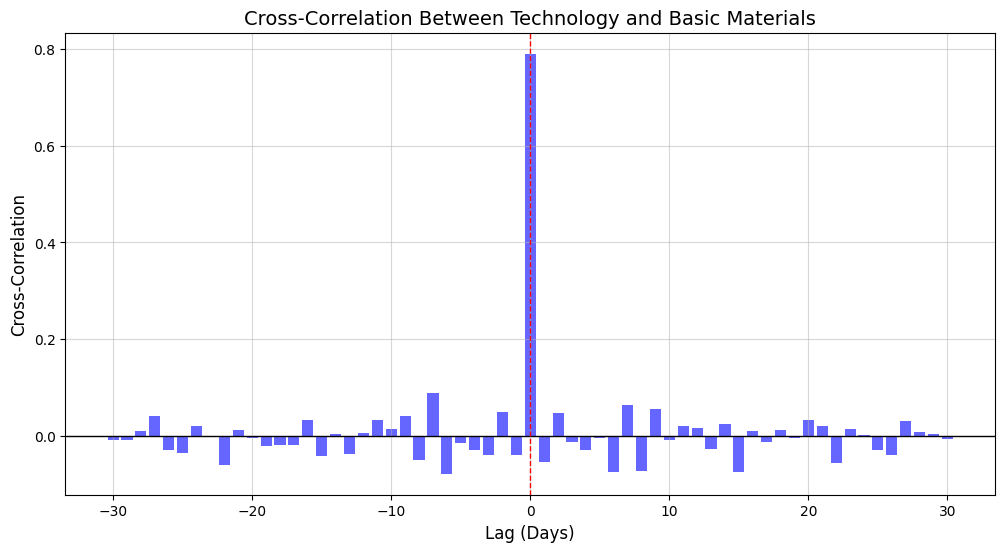

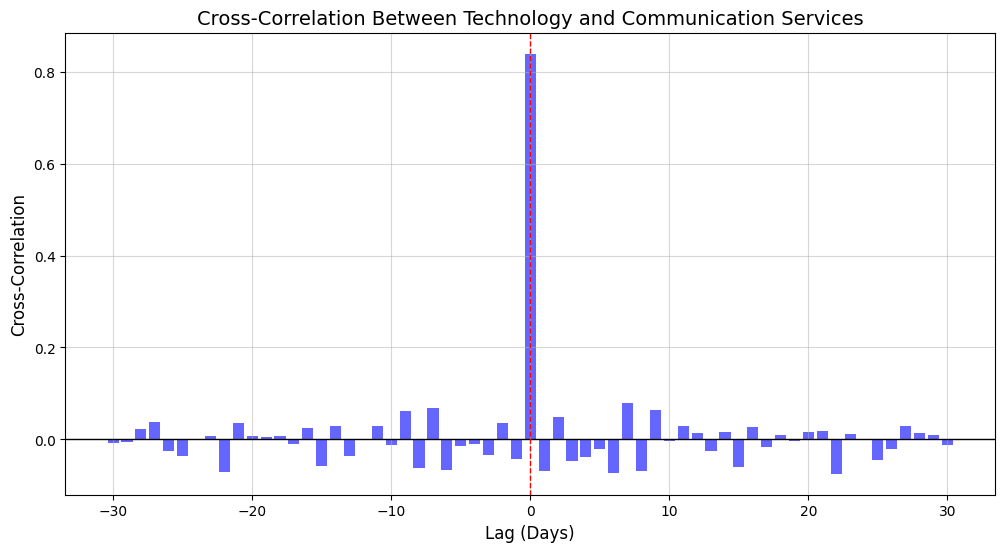

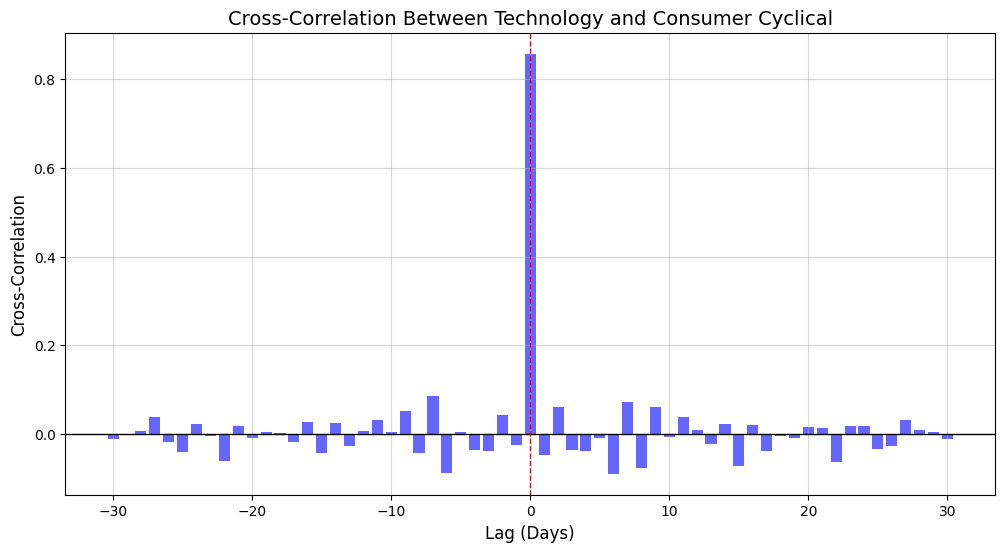

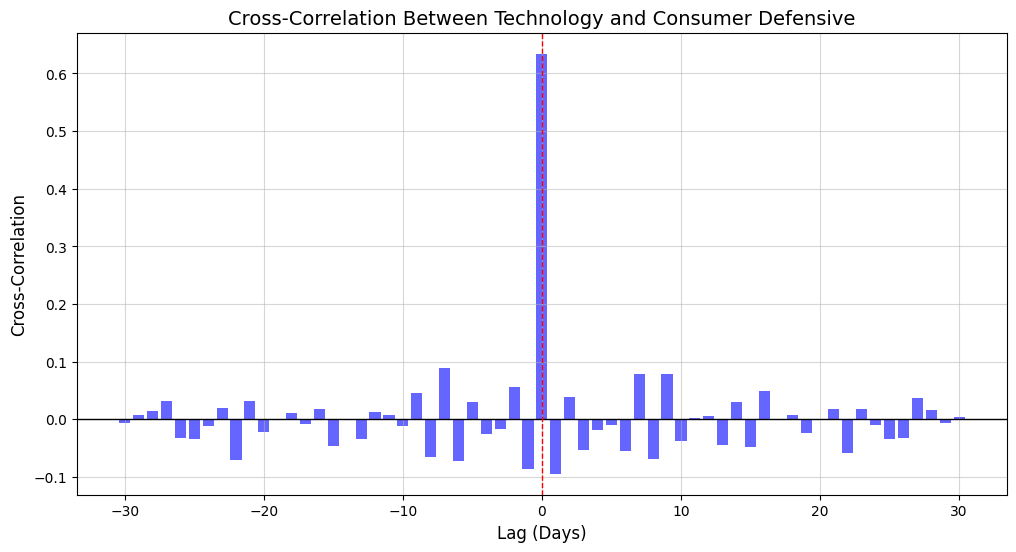

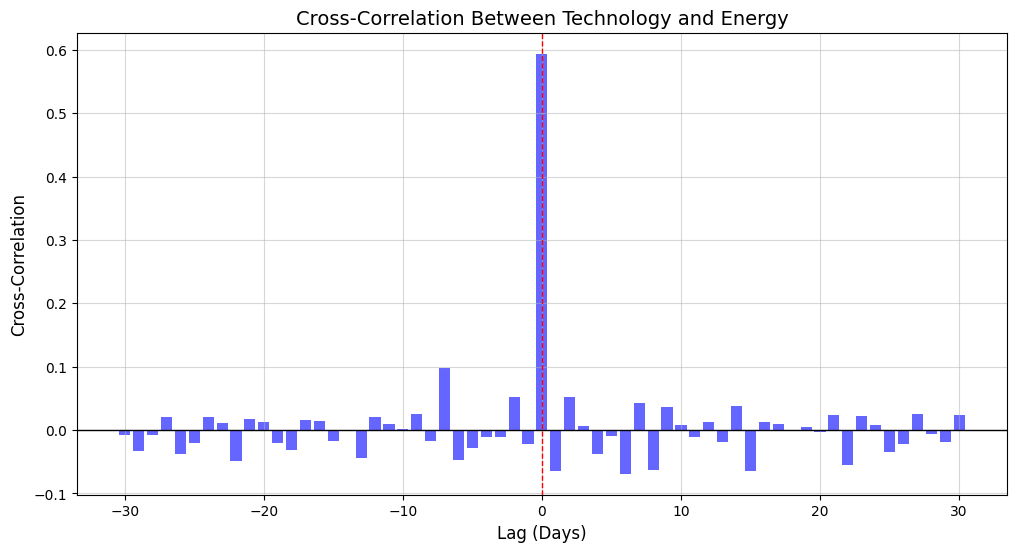

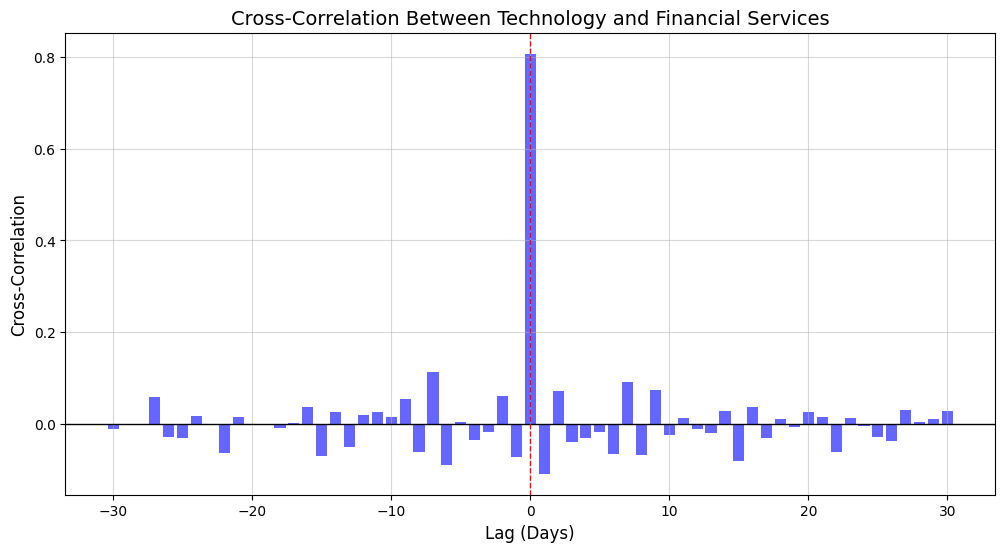

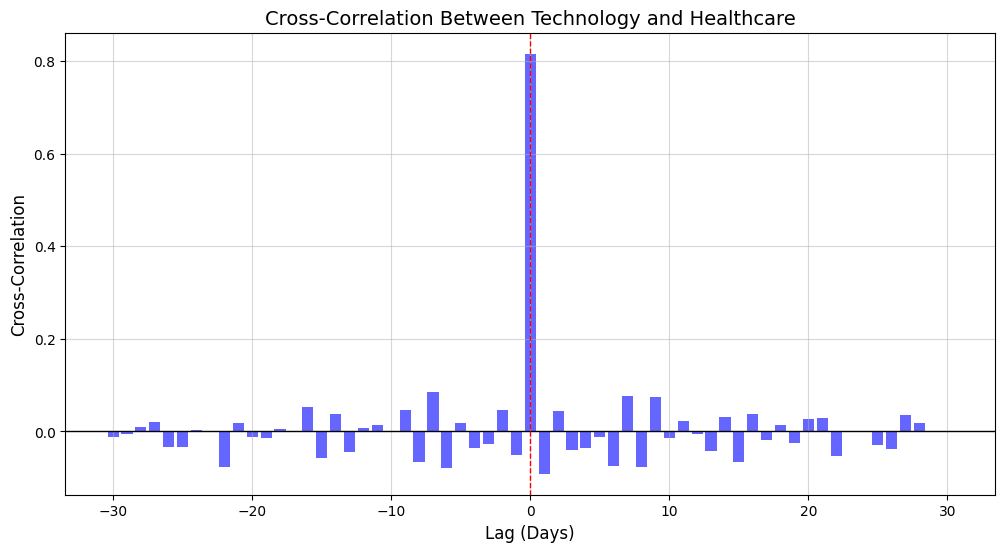

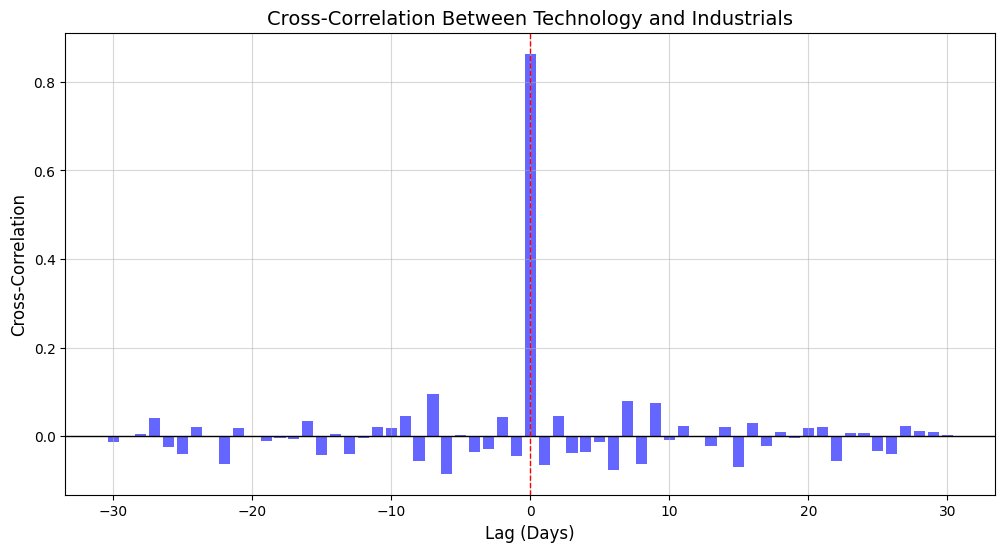

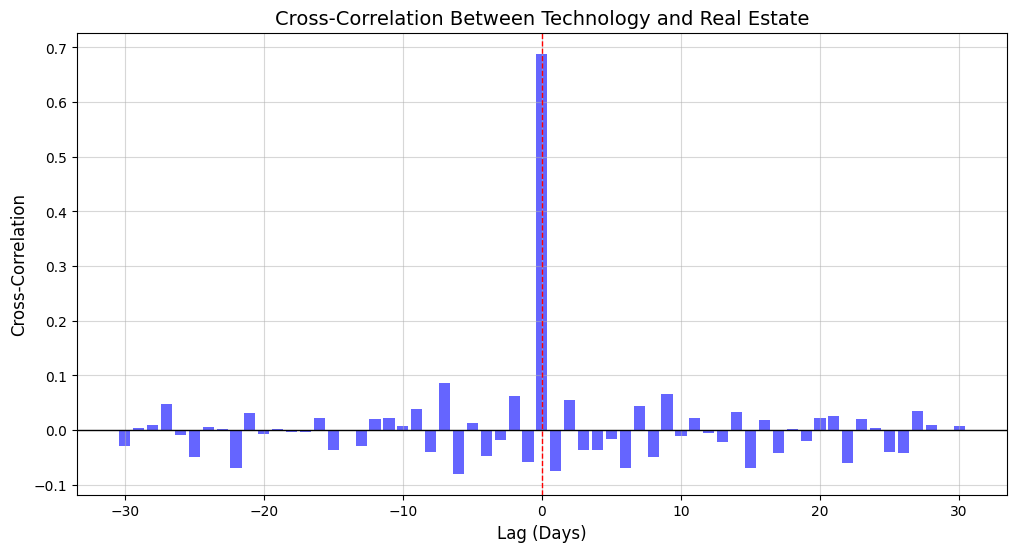

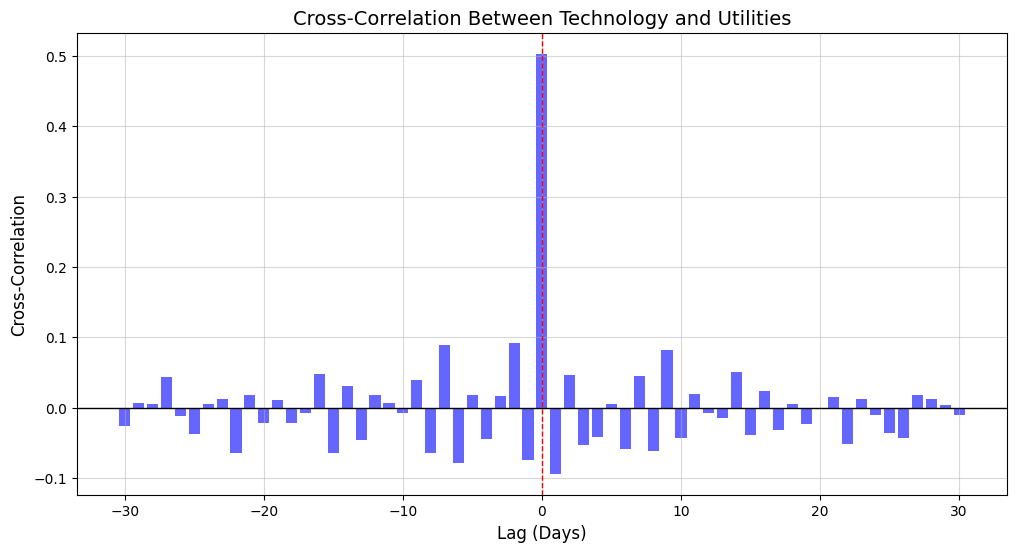

In [88]:
# List of all sectors except Technology
all_sectors = sector_returns.columns.tolist()
all_sectors.remove("Technology")  # Exclude Technology itself

max_lag = 30  # Number of days to check for leading/lagging effects

# Loop through all sectors and compute cross-correlation with Technology
for sector_2 in all_sectors:
    sector_1 = "Technology"

    # Extract time series data for the selected sectors
    sector_1_returns = sector_returns[sector_1].dropna()
    sector_2_returns = sector_returns[sector_2].dropna()

    # Align both series to have the same dates
    common_dates = sector_1_returns.index.intersection(sector_2_returns.index)
    sector_1_returns = sector_1_returns.loc[common_dates]
    sector_2_returns = sector_2_returns.loc[common_dates]

    # Compute cross-correlation
    cross_correlation = [
        sector_1_returns.corr(sector_2_returns.shift(lag))
        for lag in range(-max_lag, max_lag + 1)
    ]

    # Create figure with transparent background
    plt.figure(figsize=(12, 6), facecolor='none')

    # Plot cross-correlation
    lags = np.arange(-max_lag, max_lag + 1)
    plt.bar(lags, cross_correlation, color="b", alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='red', linestyle="--", linewidth=1)  # Mark lag=0
    plt.xlabel("Lag (Days)", fontsize=12)
    plt.ylabel("Cross-Correlation", fontsize=12)
    plt.title(f"Cross-Correlation Between {sector_1} and {sector_2}", fontsize=14)
    plt.grid(True, alpha=0.5)  # Grid with transparency
    plt.gca().set_facecolor('none')  # Transparent axes background

    # Show the plot
    plt.show()


**Strongest correlation is always at lag = 0**

*   This means that Technology and other sectors move together rather than leading or lagging each other.
*   Suggests that macroeconomic factors drive simultaneous reactions across industries.

**No significant leading/lagging relationships**

*   No consistent positive or negative correlation at positive/negative lags.
*   Technology is not a strong predictor of other sectors’ movements in this analysis.

**Industries with Higher Correlation at Lag = 0:**

*   Communication Services & Technology → Expected since digital businesses overlap.
*   Consumer Cyclical & Technology → Likely due to economic trends affecting both.
*   Financial Services & Technology → Driven by fintech innovations and market sentiment.

**Industries with Lower Correlation:**

*   Energy & Technology → Different market drivers (oil vs. innovation cycles).
*   Utilities & Technology → Utilities are defensive, while tech is growth-oriented.

**🚀 Cross-Correlation: Industrials vs. Other Sectors**

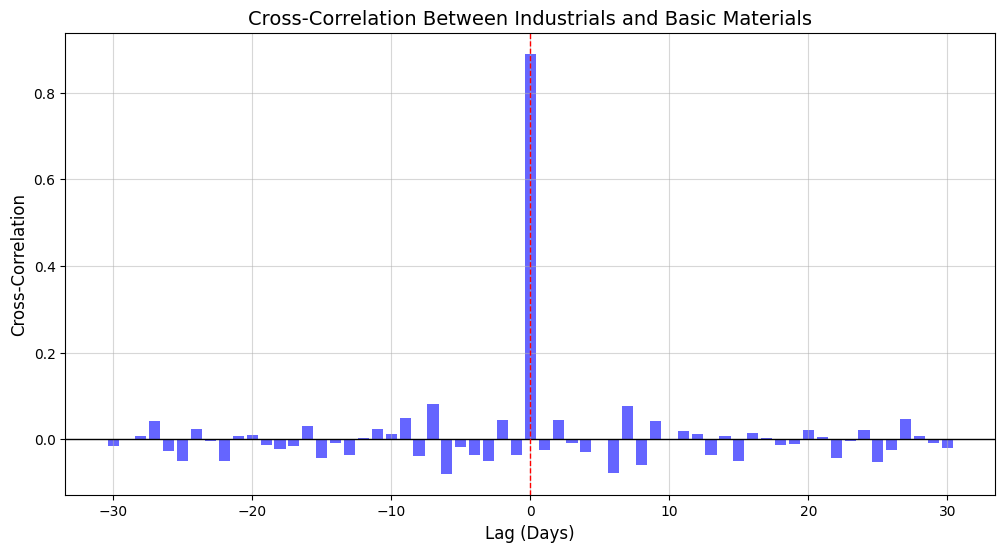

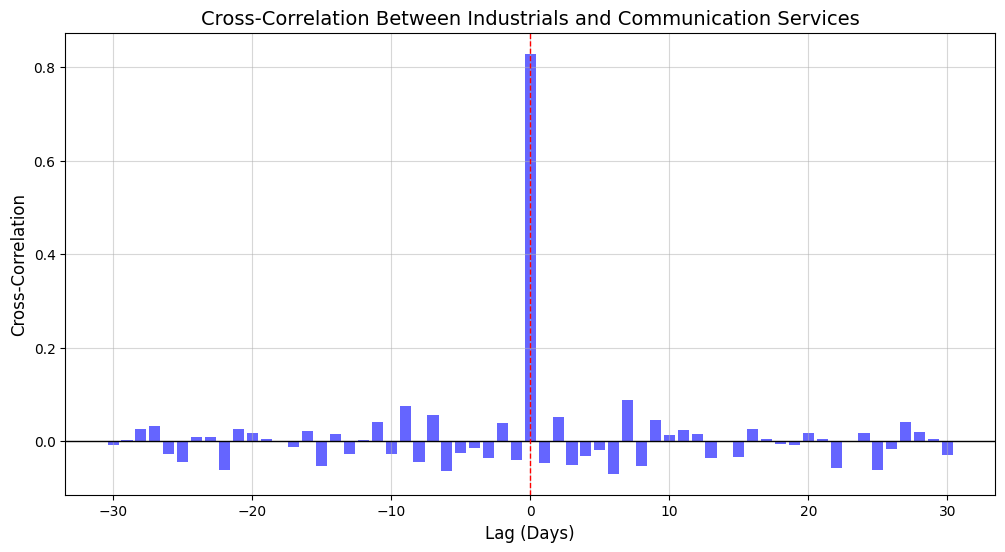

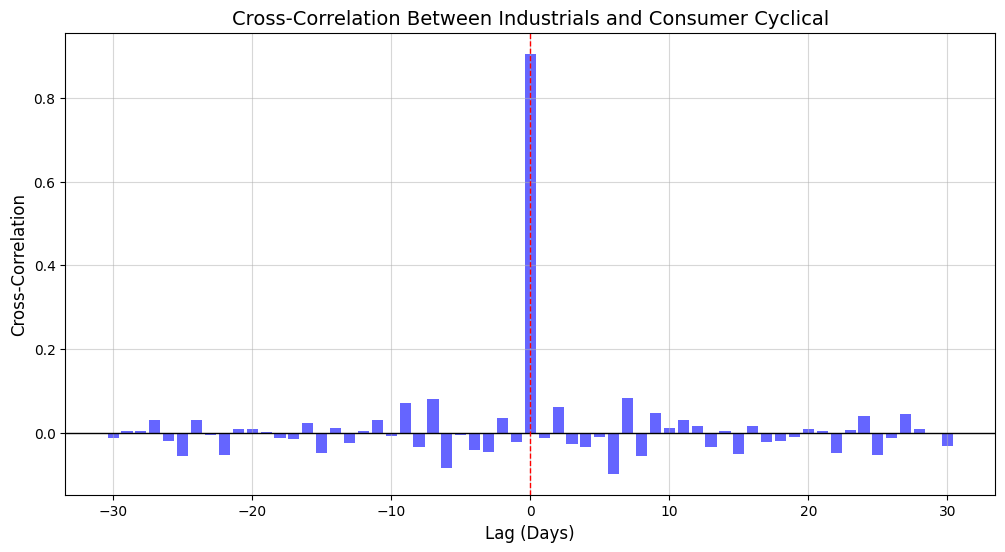

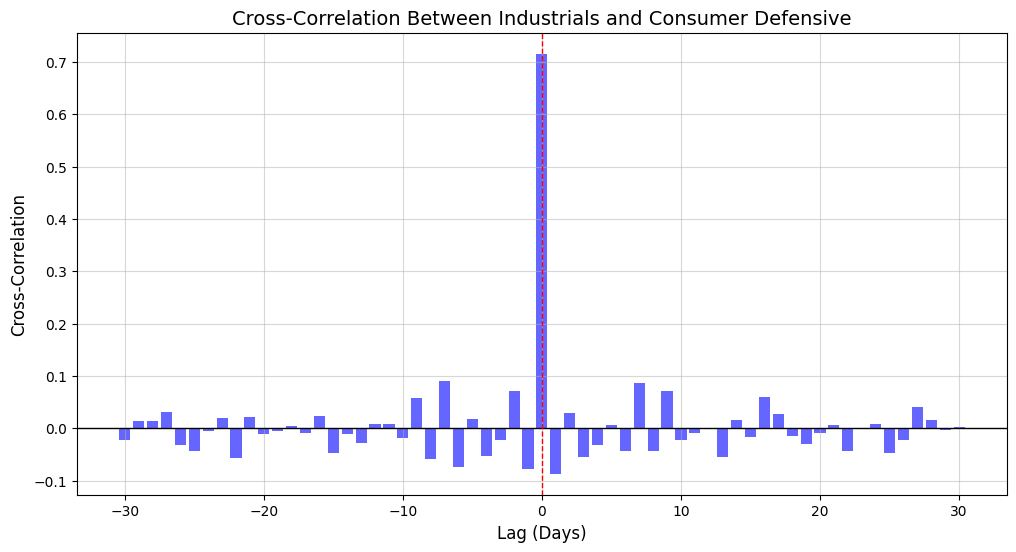

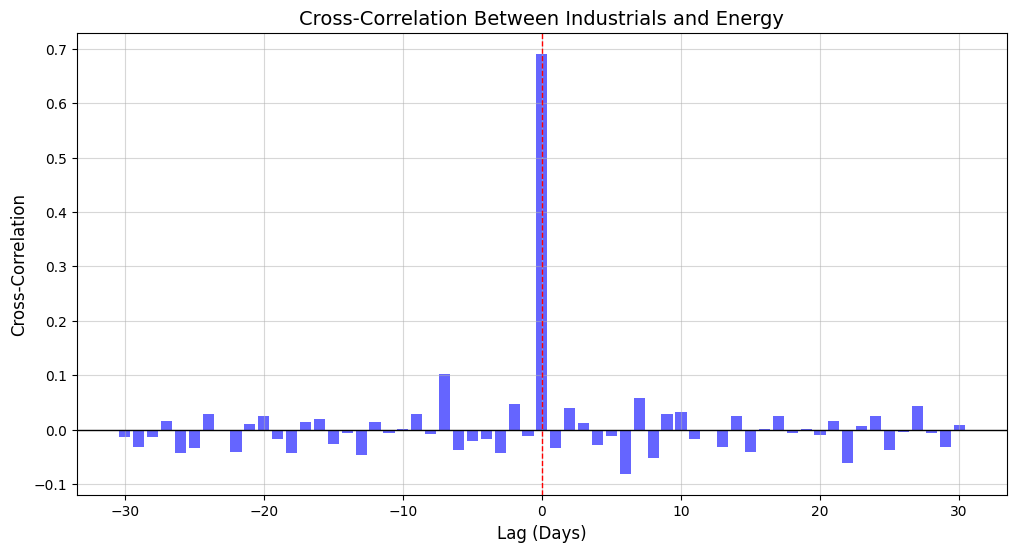

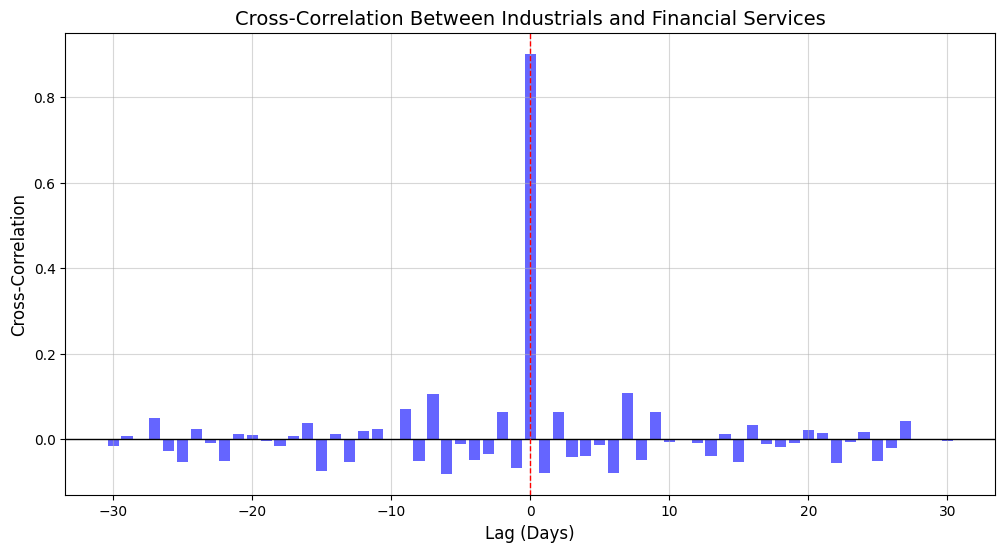

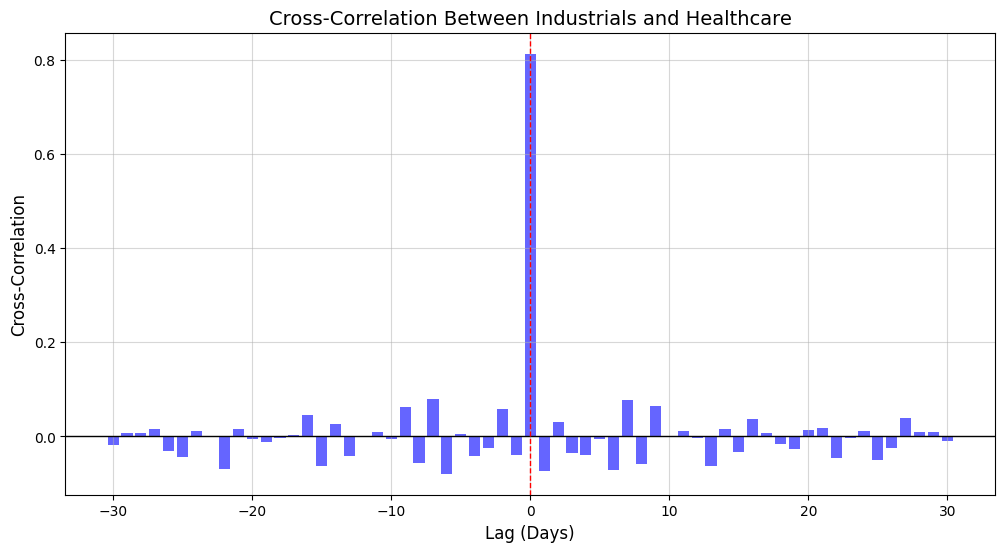

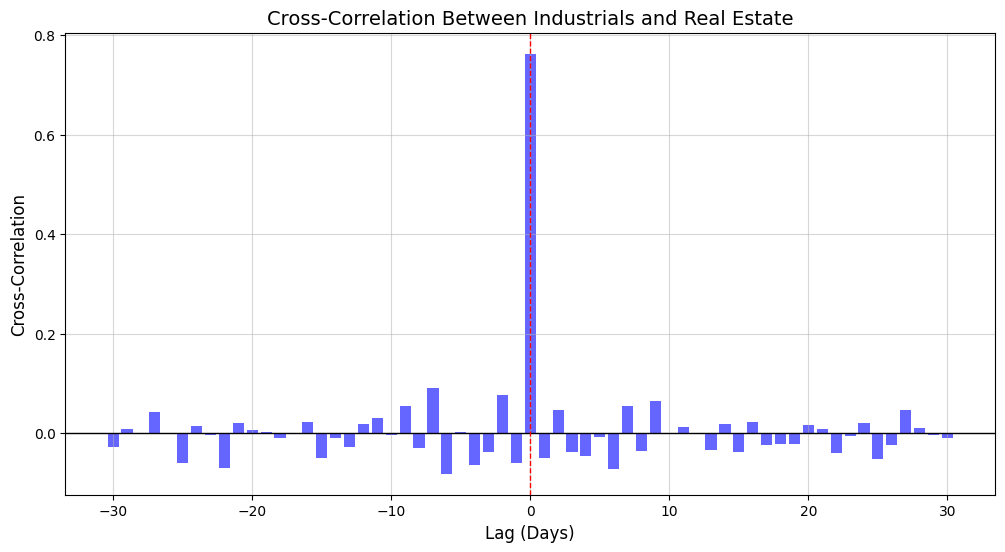

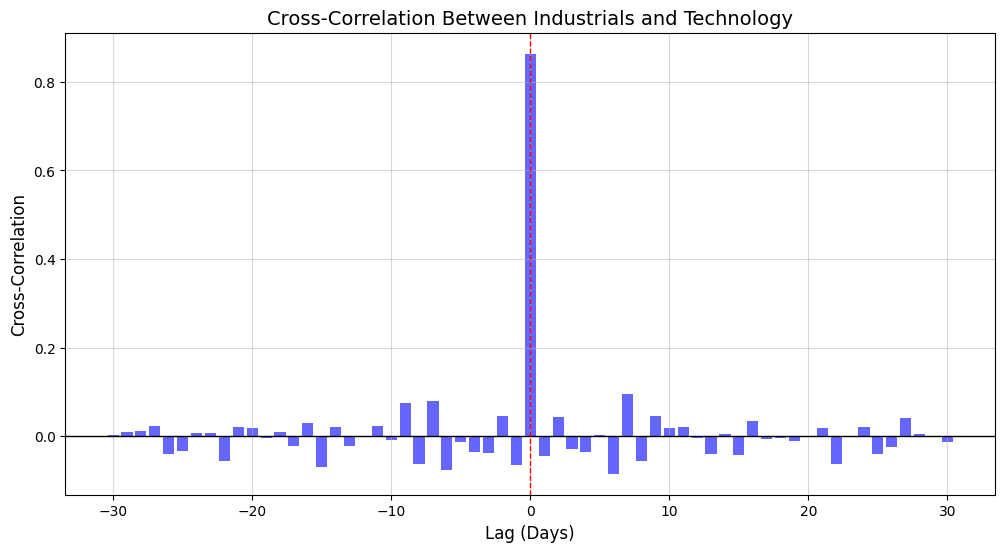

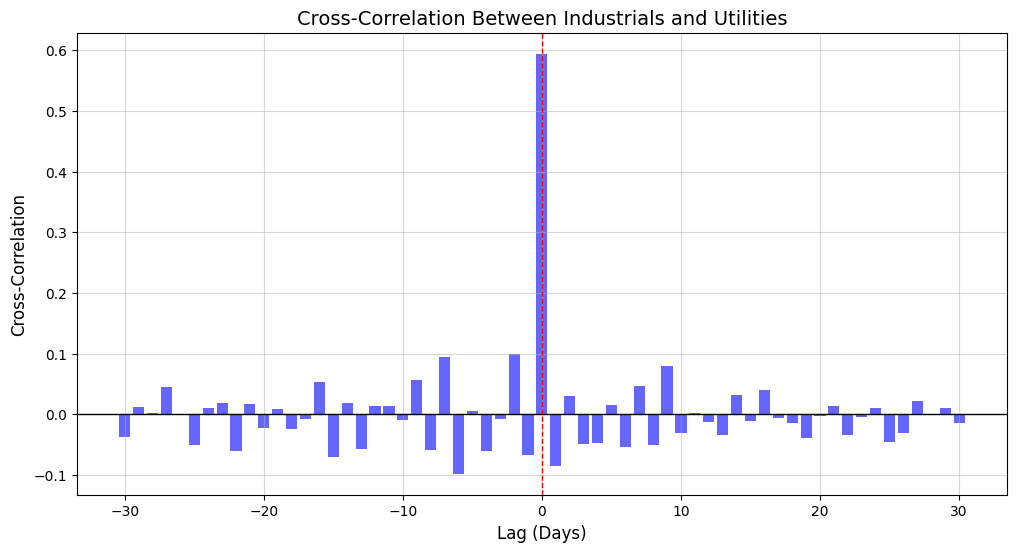

In [89]:
# List of all sectors except Industrials
all_sectors = sector_returns.columns.tolist()
all_sectors.remove("Industrials")

max_lag = 30  # Number of days to check for leading/lagging effects

# Loop through all sectors and compute cross-correlation with Industrials
for sector_2 in all_sectors:
    sector_1 = "Industrials"

    # Extract time series data for the selected sectors
    sector_1_returns = sector_returns[sector_1].dropna()
    sector_2_returns = sector_returns[sector_2].dropna()

    # Align both series to have the same dates
    common_dates = sector_1_returns.index.intersection(sector_2_returns.index)
    sector_1_returns = sector_1_returns.loc[common_dates]
    sector_2_returns = sector_2_returns.loc[common_dates]

    # Compute cross-correlation
    cross_correlation = [
        sector_1_returns.corr(sector_2_returns.shift(lag))
        for lag in range(-max_lag, max_lag + 1)
    ]

    # Create figure with transparent background
    plt.figure(figsize=(12, 6), facecolor='none')

    # Plot cross-correlation
    lags = np.arange(-max_lag, max_lag + 1)
    plt.bar(lags, cross_correlation, color="b", alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='red', linestyle="--", linewidth=1)  # Mark lag=0
    plt.xlabel("Lag (Days)", fontsize=12)
    plt.ylabel("Cross-Correlation", fontsize=12)
    plt.title(f"Cross-Correlation Between {sector_1} and {sector_2}", fontsize=14)
    plt.grid(True, alpha=0.5)  # Grid with transparency
    plt.gca().set_facecolor('none')  # Transparent axes background

    # Show the plot
    plt.show()

**📊 Pairwise Scatterplots – Visualizes relationships between industry returns.**

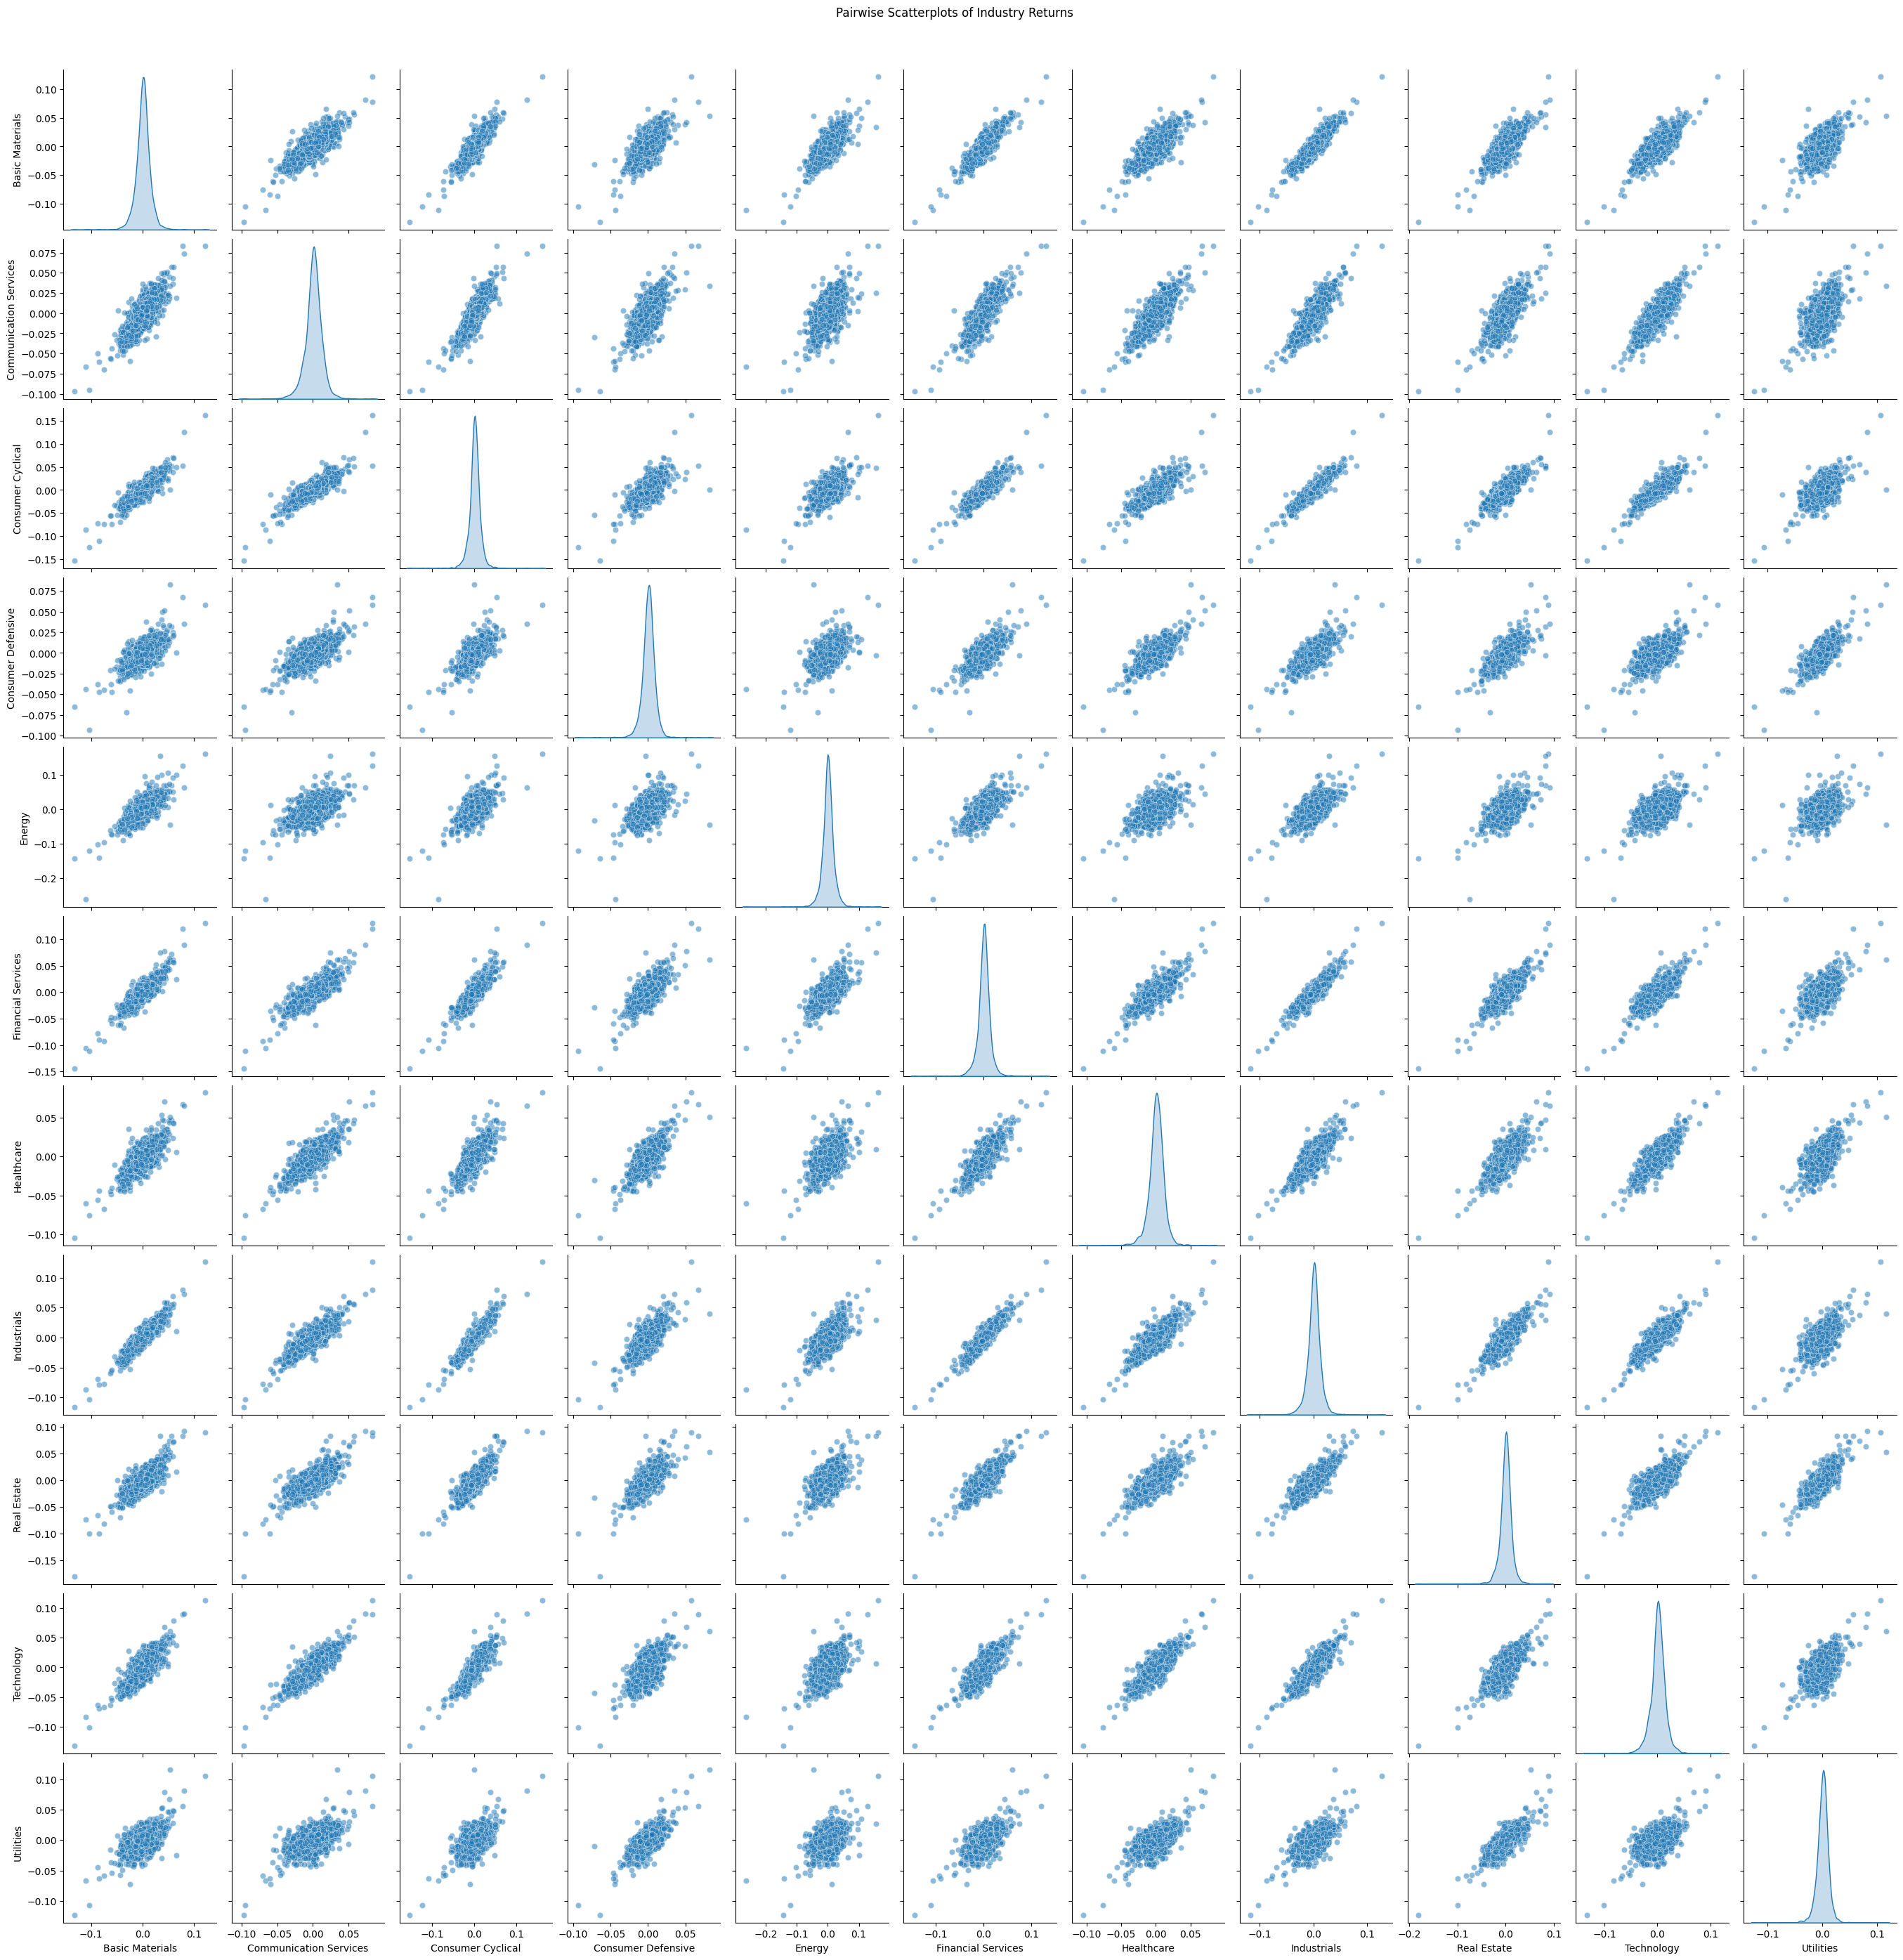

In [90]:
# Create pairwise scatterplots with transparent background
pairplot = sns.pairplot(sector_returns, kind="scatter", plot_kws={"alpha": 0.5}, diag_kind="kde")
pairplot.fig.set_facecolor('none')  # Transparent figure background
plt.suptitle("Pairwise Scatterplots of Industry Returns", y=1.02)

# Show the plot
plt.show()

**Strong Linear Relationships Between Some Sectors**

*   Certain sectors show clear positive correlations (e.g., Technology & Communication Services, Financial Services & Consumer Cyclical).
*   These relationships suggest industries that tend to move together due to common market forces.

**Weaker or No Clear Patterns in Other Pairs**

*   Some industries, like Energy vs. Technology, Utilities vs. Financial Services, show more dispersed points, indicating a weaker relationship.
*   This is expected since Energy is commodity-driven while Technology follows innovation cycles.

**Densely Clustered Distributions**

*   The diagonal KDE plots show the return distributions of each sector.
*   Most sectors have normal-looking distributions, but some might have fat tails, indicating occasional large moves.

**📉 Clustering Dendrogram – Groups industries with similar return behaviors.**

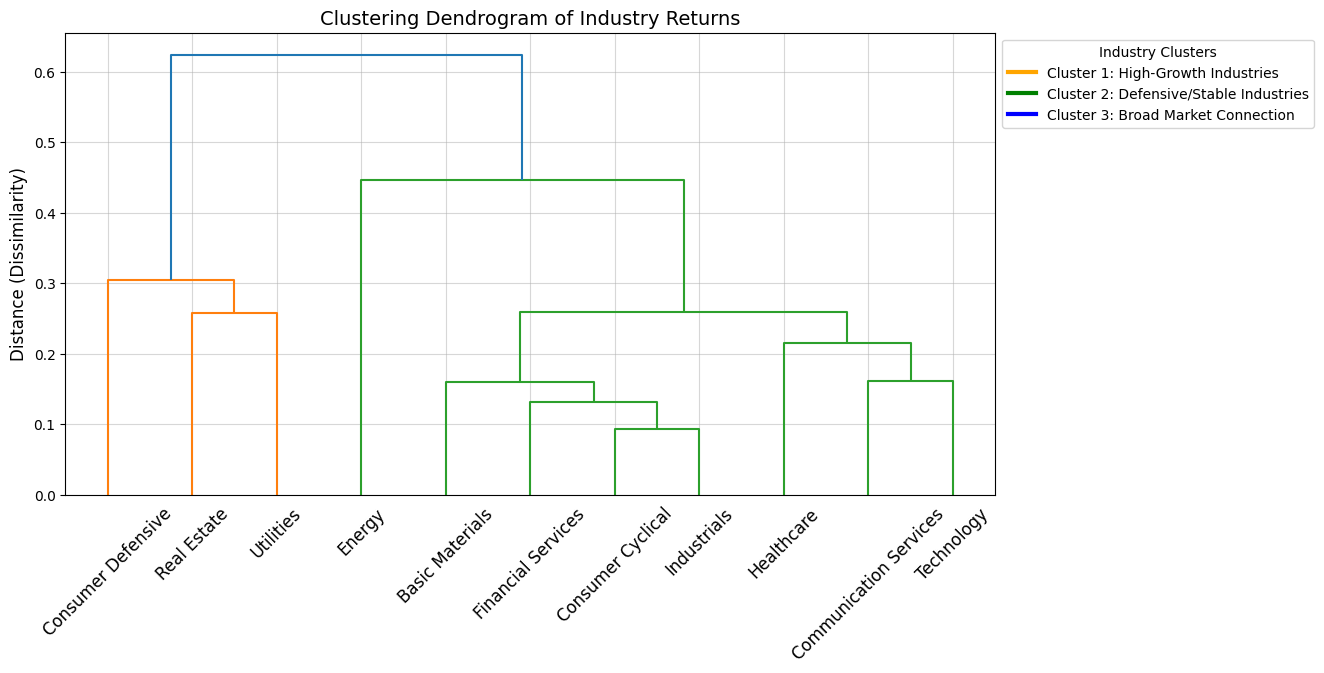

In [91]:
# Compute correlation matrix of industry returns
industry_correlation = sector_returns.corr()

# Convert correlation to distance metric (1 - correlation)
distance_matrix = 1 - industry_correlation

# Perform hierarchical clustering
linkage_matrix = sch.linkage(squareform(distance_matrix), method="ward")

# Create figure with transparent background
plt.figure(figsize=(12, 6), facecolor='none')

# Plot dendrogram with color threshold to group clusters
dendrogram = sch.dendrogram(
    linkage_matrix, labels=industry_correlation.index, leaf_rotation=45, color_threshold=0.6
)

plt.title("Clustering Dendrogram of Industry Returns", fontsize=14)
plt.ylabel("Distance (Dissimilarity)", fontsize=12)
plt.grid(True, alpha=0.5)  # Grid with transparency
plt.gca().set_facecolor('none')  # Transparent axes background

# Create a legend
legend_patches = [
    plt.Line2D([0], [0], color='orange', lw=3, label="Cluster 1: High-Growth Industries"),
    plt.Line2D([0], [0], color='green', lw=3, label="Cluster 2: Defensive/Stable Industries"),
    plt.Line2D([0], [0], color='blue', lw=3, label="Cluster 3: Broad Market Connection")  # If meaningful
]
plt.legend(handles=legend_patches, title="Industry Clusters", bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.show()


**Industries are grouped into clusters based on their return correlations**

*   The closer two industries are, the more similarly they behave in terms of daily returns.
*   The vertical height of the branches represents the distance (dissimilarity) between clusters.

**Clear industry groupings:**

*   Cluster 1 (Orange): Basic Materials, Financial Services, Consumer Cyclical, Industrials, Healthcare, Communication Services, Technology
  *   These sectors tend to be growth-sensitive, moving together based on economic cycles.
  *   Industrials & Consumer Cyclical are closely linked, which makes sense since industrial production affects consumer demand.

*   Cluster 2 (Blue): Energy
  *   Energy moves more independently, likely due to commodity price fluctuations.

*   Cluster 3 (Green): Utilities, Consumer Defensive, Real Estate
  *   These are defensive sectors that tend to be stable, often moving independently from the growth-sensitive sectors.

**Energy is an outlier**

*   It clusters separately from most industries, reinforcing that oil price movements drive it rather than general market trends.

**📈 PCA (Principal Component Analysis) Plot – Identifies major market trends.**

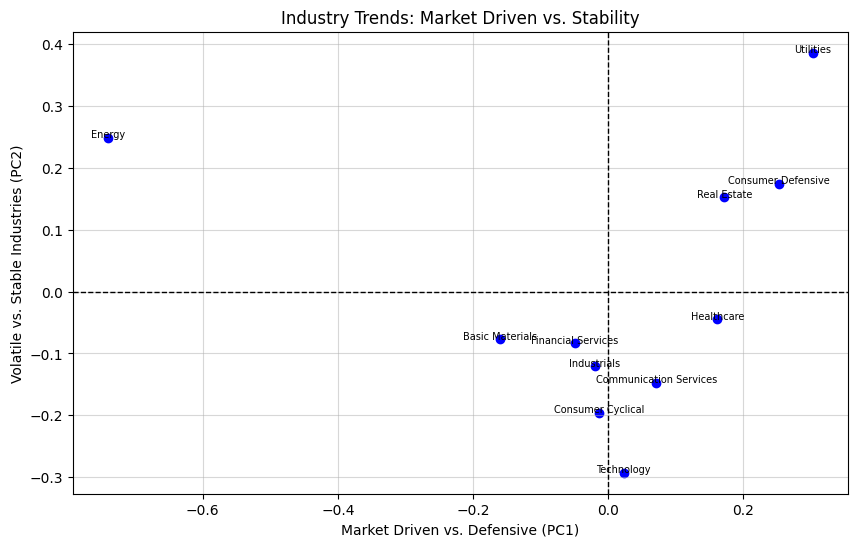

In [92]:
# Standardize the sector return data (remove NaNs first)
sector_returns_cleaned = sector_returns.dropna()

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(sector_returns_cleaned.T)  # Transpose to analyze sectors

# Create DataFrame for visualization
pca_df = pd.DataFrame(
    principal_components, index=sector_returns_cleaned.columns, columns=["PC1", "PC2"]
)

# Create figure with transparent background
plt.figure(figsize=(10, 6), facecolor='none')

# Plot PCA results with updated labels
plt.scatter(pca_df["PC1"], pca_df["PC2"], color="blue")

# Annotate sectors with updated explanations
for sector, (x, y) in pca_df.iterrows():
    plt.text(x, y, sector, fontsize=7, ha="center")

# Update axis labels for non-data science audience
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Market Driven vs. Defensive (PC1)")
plt.ylabel("Volatile vs. Stable Industries (PC2)")
plt.title("Industry Trends: Market Driven vs. Stability")
plt.grid(True, alpha=0.5)  # Grid with transparency
plt.gca().set_facecolor('none')  # Transparent axes background

# Show the plot
plt.show()

🔹 How to Interpret the Graph

*   The x-axis (PC1) represents the main factor affecting industry movements.
  *   Industries close to each other on this axis behave similarly.
*   The y-axis (PC2) represents a secondary factor affecting industry movements.
  *   Industries further apart may have different market drivers.
*   Clusters of industries suggest they move together in the market.

*   Principal Component 1 → "Market Growth vs. Defensive Stability"
  *   Left Side: Industries that respond to market conditions (e.g., Energy, Financial Services).
  *   Right Side: Industries that are stable, even in downturns (e.g., Utilities, Real Estate).
*   Principal Component 2 → "Volatile vs. Stable Industries"
  *   Top: Industries with fewer sudden movements (e.g., Utilities, Consumer Defensive).
  *   Bottom: Industries that experience higher swings (e.g., Technology, Consumer Cyclical).











# Regression Models


*   Linear Regression Model (Mau Pallares) - Predict Closing Price
*   Logistic Regression Model (Jose Marin) - Predict if the price is going up or down





# Setting up data for Model

*   Checking for Nan Values
*   Replacing Nan values with median



In [93]:
row_counts = final_df.shape
print(row_counts)

Nan_num = final_df.isna().sum()
Nan_num

(1768528, 10)


,0
Date,0
Symbol,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0
Sector,0
Daily Return,503


In [94]:
# Get total number of rows in the DataFrame
total_rows = len(final_df)

# Count rows with at least one missing value
rows_with_missing = final_df.isna().any(axis=1).sum()

# Calculate percentage of rows with missing values
percent_rows_with_missing = (rows_with_missing / total_rows) * 100

# Print results
print(f"Number of rows with at least one missing value: {rows_with_missing}")
print(f"Percentage of rows with missing values: {percent_rows_with_missing:.2f}%")

Number of rows with at least one missing value: 503
Percentage of rows with missing values: 0.03%


In [95]:
# Select only numeric columns for median calculation
numeric_cols = final_df.select_dtypes(include='number').columns

# Function to fill NaN with row median
def fill_with_row_median(row):
    if row.isna().any():
        row_median = row[numeric_cols].median()  # Median of numeric values in this row
        return row.fillna(row_median)  # Fill NaN with row median
    return row  # Return unchanged if no NaN

# Apply the function to each row
final_df = final_df.apply(fill_with_row_median, axis=1)

In [96]:
# Sanity Check
assert final_df.isna().sum().max() == 0
final_df.isna().sum()

,0
Date,0
Symbol,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0
Sector,0
Daily Return,0


In [97]:
summary_stats = final_df.describe()
summary_stats

,Date,Adj Close,Close,High,Low,Open,Volume,Daily Return
count,1768528,1.768528e+06,1.768528e+06,1.768528e+06,1.768528e+06,1.768528e+06,1.768528e+06,1.768528e+06
mean,2017-07-25 21:10:47.415704064,9.560818e+01,1.035795e+02,1.047038e+02,1.023979e+02,1.035603e+02,7.028473e+06,1.072647e-02
min,2010-01-04 00:00:00,2.036069e-01,2.220000e-01,2.262500e-01,2.162500e-01,2.180000e-01,0.000000e+00,-5.386473e-01
25%,2013-12-06 00:00:00,2.846095e+01,3.465000e+01,3.501000e+01,3.424614e+01,3.464000e+01,1.014200e+06,-8.004056e-03
50%,2017-08-23 00:00:00,5.301138e+01,6.232000e+01,6.294000e+01,6.164000e+01,6.230000e+01,2.202300e+06,7.747470e-04
75%,2021-03-31 00:00:00,1.018700e+02,1.125900e+02,1.137500e+02,1.113700e+02,1.125700e+02,5.048200e+06,9.540641e-03
max,2024-10-10 00:00:00,9.892300e+03,9.892300e+03,9.912560e+03,9.728990e+03,9.839980e+03,3.692928e+09,7.126700e+02
std,NaN,2.099989e+02,2.104033e+02,2.128088e+02,2.079031e+02,2.103140e+02,3.316062e+07,9.011552e-01


# Logistic Regression Model Version 1

**Setting Up Data Target (y)**

In [98]:
# Calculate raw daily change
final_df['Daily Change'] = final_df['Close'].diff()

# Define target: 1 if price goes up, 0 if down or same
final_df['Target'] = (final_df['Daily Change'] > 0).astype(int)

# Drop NaN (first row has no prior day)
final_df = final_df.dropna()

In [99]:
final_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Sector,Daily Return,Daily Change,Target
1,2010-01-05,MMM,43.741009,68.979935,69.590302,68.311035,69.230766,3405012.0,Industrials,-0.006264,-0.434784,0
2,2010-01-06,MMM,44.361355,69.958191,70.735786,69.824417,70.133781,6301126.0,Industrials,0.014182,0.978256,1
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0,Industrials,0.000717,0.050171,1
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0,Industrials,0.007047,0.493309,1
5,2010-01-11,MMM,44.525715,70.217392,70.735786,69.740807,70.551842,3500812.0,Industrials,-0.004032,-0.284279,0


**Setting up features (X)**

In [100]:
# Add features with raw differences
final_df['Lag1_Change'] = final_df['Daily Change'].shift(1)
final_df['Price_Range'] = final_df['High'] - final_df['Low']
final_df['Volume_Change'] = final_df['Volume'].diff()
final_df['Open_Close_Change'] = final_df['Close'] - final_df['Open']
final_df['Lag1_Close'] = final_df['Close'].shift(1)

# Drop NaN rows (from lagging)
final_df = final_df.dropna()

### **Running Model Version 1**

In [101]:
# Initialize model
logr = LogisticRegression(max_iter=1000)

# Split the dataframe (time-series, no shuffle)
train_df, test_df = train_test_split(final_df, train_size=0.8, test_size=0.2, shuffle=False)

# Check sizes
print(f"Total rows in df: {len(final_df)}")
print(f"Train size: {len(train_df)} ({len(train_df)/len(final_df)*100:.2f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(final_df)*100:.2f}%)")
print(f"\nExpected test_df size: {int(0.2 * final_df.shape[0])}")
print(f"Actual test_df size: {test_df.shape[0]}")

Total rows in df: 1768526
Train size: 1414820 (80.00%)
Test size: 353706 (20.00%)

Expected test_df size: 353705
Actual test_df size: 353706


In [102]:
# Define feature and target columns
feat_cols = ['Lag1_Change', 'Price_Range', 'Volume_Change', 'Open_Close_Change', 'Lag1_Close']
target_col = 'Target'

# Extract X and y
X_train = train_df[feat_cols]
y_train = train_df[target_col]

X_test = test_df[feat_cols]
y_test = test_df[target_col]

# Train model
logr.fit(X_train, y_train)

# Predict and evaluate
y_pred = logr.predict(X_test)

In [103]:
# Get model coefficients
intercept = logr.intercept_
coefs = logr.coef_

print("Logistic Regression Coefficients:", coefs)
print("Logistic Regression Intercept:", intercept)

Logistic Regression Coefficients: [[-6.93213082e-04 -1.26377528e-01 -2.68698132e-10  2.09452672e+00
   2.51967211e-03]]
Logistic Regression Intercept: [0.06472194]


In [104]:
# Get predicted probabilities for AUROC
y_pred_proba = logr.predict_proba(X_test)[:, 1]  # Probability for class 1

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Same as TPR
auroc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("\nLogistic Regression Metrics on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"True Positive Rate (Recall): {tpr:.2f}")
print(f"True Negative Rate: {tnr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")
print(f"False Negative Rate: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUROC: {auroc:.2f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


Logistic Regression Metrics on Test Set:
Accuracy: 0.84
True Positive Rate (Recall): 0.88
True Negative Rate: 0.80
False Positive Rate: 0.20
False Negative Rate: 0.12
Precision: 0.83
Recall: 0.88
AUROC: 0.90

Confusion Matrix:
TN: 136161, FP: 33290, FN: 22587, TP: 161668


In [105]:
baseline_acc = max(y_test.mean(), 1 - y_test.mean())
print(f"Baseline Accuracy: {baseline_acc:.2f}")

Baseline Accuracy: 0.52


### **Model Analysis Version 1**

**Dataset Size:**\
Total Rows: 1,768,526\
Train: 1,414,820 (80%)\
Test: 353,706 (20%)

**Expected vs. Actual:** Off by 1 row (353,705 vs. 353,706), likely due to rounding in int(0.2 * final_df.shape[0]), but the split is correct.

**Interpretation:** If it’s just MMM, it’s daily data for 7,000+ trading days (~28 years), or you have multiple symbols (e.g., ~500 stocks × 14 years × 252 days ≈ 1.76M). Either way, the scale supports an 80-20 split.

**Model Performance:**\
Accuracy: 0.84 (84%)
Strong, but compare to a baseline (e.g., always predict the majority class: y_test.mean() or 1 - y_test.mean()).

**Confusion Matrix:**\
TN: 136,161 (correctly predicted downs)\
FP: 33,290 (downs predicted as ups)\
FN: 22,587 (ups predicted as downs)\
TP: 161,668 (correctly predicted ups)\
Total: 353,706 ✓

**Metrics:**\
TPR (Recall): 0.88 (88% of ups correctly predicted)\
TNR (Specificity): 0.80 (80% of downs correctly predicted)\
FPR: 0.20 (20% of downs misclassified as ups)\
FNR: 0.12 (12% of ups misclassified as downs)\
Precision: 0.83 (83% of predicted ups were correct)\
AUROC: 0.90 (excellent ability to distinguish up vs. down)

**Coefficients:**
Lag1_Change: -0.000693 (small negative effect)
Price_Range: -0.126 (moderate negative effect)
Volume_Change: -2.69e-10 (near-zero effect)
Open_Close_Change: 2.095 (strong positive effect)
Lag1_Close: 0.00252 (small positive effect)
Intercept: 0.0647

**Insight:**\
Open_Close_Change dominates prediction—daily price movement within the day strongly predicts the next day’s direction.

**Baseline Comparison:**\
Test set: 353,706 rows\
Ups (Target = 1): TP + FN = 161,668 + 22,587 = 184,255 (52.1%)\
Downs (Target = 0): TN + FP = 136,161 + 33,290 = 169,451 (47.9%)\
Baseline Accuracy: Always predict 1 → 52.1%. \
84% beats this by a wide margin.

**Overview of Metrics**\
The model predicts whether a stock (likely MMM or multiple stocks) goes up (1) or down (0) the next day, using features like Lag1_Change, Price_Range, Volume_Change, Open_Close_Change, and Lag1_Close. The test set has:

Total rows: 353,706\
Class distribution: ~52% ups (184,255 = TP + FN), ~48% downs (169,451 = TN + FP)

1. Accuracy: 0.84 (84%)
Definition: Proportion of correct predictions out of total predictions: (TP + TN) / (TP + TN + FP + FN) = (161,668 + 136,161) / 353,706 ≈ 0.84.
Interpretation: The model correctly predicts 84% of stock movements (up or down). This is solid for stock prediction, where random guessing (52% baseline, always predict up) would achieve ~52%.
Strength: Beats the baseline by a wide margin (32% improvement), indicating the model learns meaningful patterns.
Weakness: Accuracy alone doesn’t tell the whole story—check precision, recall, and AUROC for imbalances or trade-offs.
2. True Positive Rate (Recall): 0.88 (88%)
Definition: Proportion of actual ups correctly predicted: TP / (TP + FN) = 161,668 / (161,668 + 22,587) ≈ 0.88.
Interpretation: The model identifies 88% of days when the stock goes up. This is excellent, suggesting it’s good at capturing rising prices.
Strength: High recall means few missed opportunities (false negatives, 22,587) if you’re trading or investing in ups.
Weakness: Could miss 12% of ups, which might be costly in trading contexts where capturing all ups is critical. Compare to precision to see trade-offs.
3. True Negative Rate (Specificity): 0.80 (80%)
Definition: Proportion of actual downs correctly predicted: TN / (TN + FP) = 136,161 / (136,161 + 33,290) ≈ 0.80.
Interpretation: The model correctly identifies 80% of days when the stock goes down. This is solid but slightly lower than recall for ups.
Strength: Good at avoiding false positives when predicting downs, reducing unnecessary bearish positions.
Weakness: Misses 20% of downs (false positives, 33,290), which could lead to unnecessary trades or losses if you act on “down” predictions.
4. False Positive Rate: 0.20 (20%)
Definition: Proportion of actual downs misclassified as ups: FP / (FP + TN) = 33,290 / (33,290 + 136,161) ≈ 0.20.
Interpretation: 20% of downs are incorrectly predicted as ups. This is the complement of specificity (1 - 0.80).
Strength: Relatively low, meaning the model doesn’t over-predict ups too often.
Weakness: Could lead to losses if you trade based on false “up” signals, especially if downs are significant drops.
5. False Negative Rate: 0.12 (12%)
Definition: Proportion of actual ups misclassified as downs: FN / (FN + TP) = 22,587 / (22,587 + 161,668) ≈ 0.12.
Interpretation: 12% of ups are incorrectly predicted as downs. This is the complement of recall (1 - 0.88).
Strength: Low, meaning few missed opportunities for bullish trades.
Weakness: Still 22,587 missed ups, which might be costly in trading if ups are profitable moves.
6. Precision: 0.83 (83%)
Definition: Proportion of predicted ups that are correct: TP / (TP + FP) = 161,668 / (161,668 + 33,290) ≈ 0.83.
Interpretation: When the model predicts an up, it’s correct 83% of the time. This is strong, indicating reliable “up” signals.
Strength: High precision means fewer wasted trades on false positives, balancing recall’s focus on capturing ups.
Weakness: Slightly lower than recall (0.88), suggesting a trade-off—some “up” predictions are incorrect, but this is expected in noisy stock data.
7. Recall (Reiterated): 0.88 (88%)
Interpretation: Already discussed, but reinforces that the model excels at finding ups, prioritizing sensitivity over specificity.
Trade-Off: High recall (88%) but slightly lower precision (83%) and specificity (80%) indicates the model favors catching ups, accepting some false positives.
8. AUROC: 0.90 (90%)
Definition: Area Under the Receiver Operating Characteristic curve, measuring the model’s ability to distinguish between ups and downs across all thresholds.
Interpretation: 0.90 is excellent—much better than random (0.5). It means the model ranks positive cases (ups) higher than negative cases (downs) 90% of the time.
Strength: Confirms the model’s overall discriminative power, aligning with the ROC curve you shared (steep rise, high TPR at low FPR).
Weakness: Could push to 0.91+ with tuning, but 0.90 is already top-tier for stock prediction.
9. Confusion Matrix
TN: 136,161, FP: 33,290, FN: 22,587, TP: 161,668
Interpretation:
Correct predictions: 297,829 (TN + TP = 84% of 353,706).
Errors: 55,877 (FP + FN = 16% of 353,706).
Ups: 184,255 total → 88% correct (TP), 12% wrong (FN).
Downs: 169,451 total → 80% correct (TN), 20% wrong (FP).
Strength: Balanced errors (33,290 FP vs. 22,587 FN), but slightly more false positives, reflecting the model’s preference for predicting ups.
Weakness: Could optimize for fewer false positives or negatives, depending on your trading strategy (e.g., prioritize avoiding losses vs. capturing gains).

### **Model Graphics Version 1**

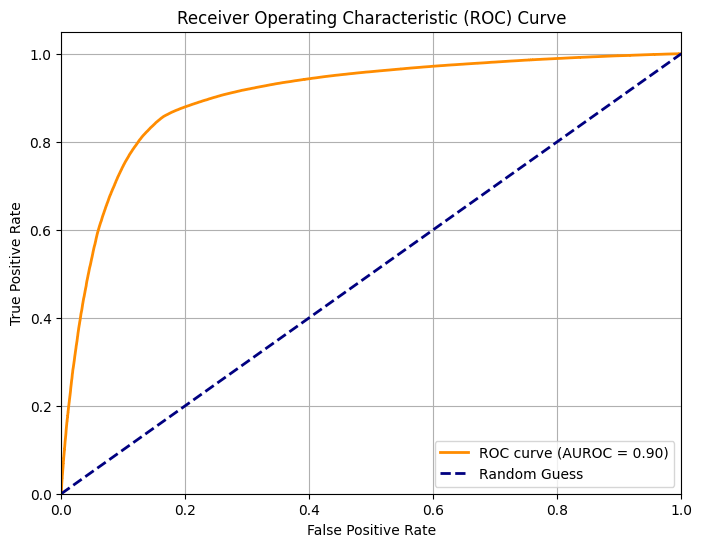

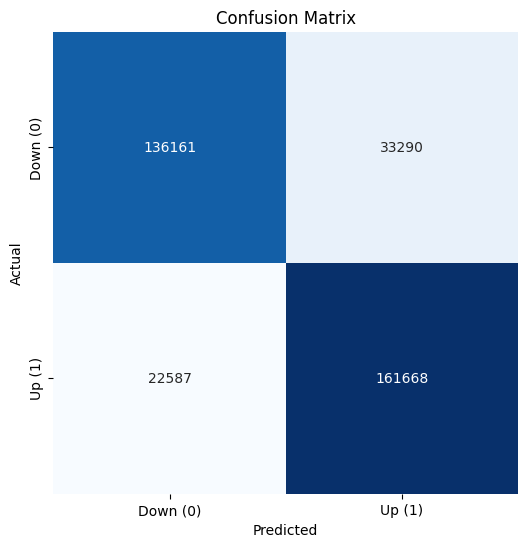

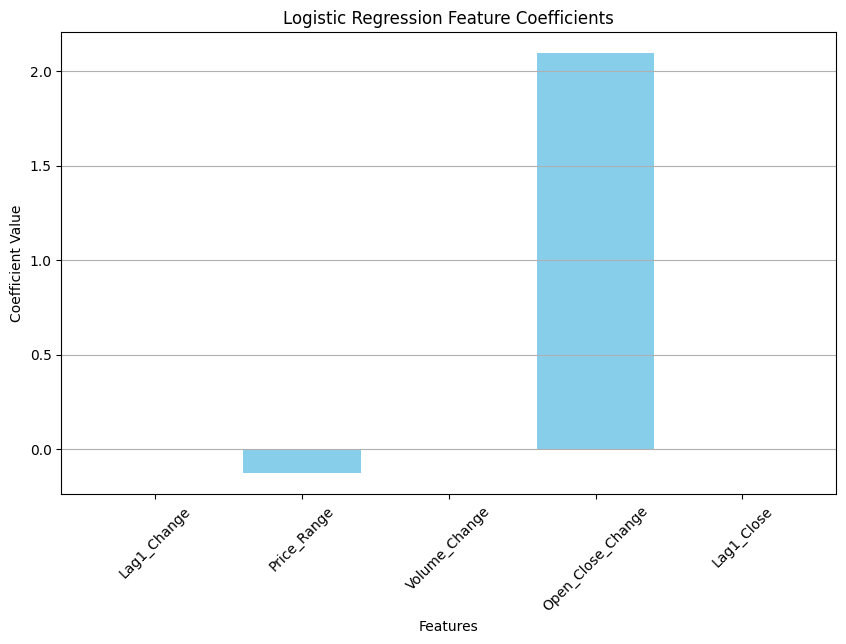

In [106]:
# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. Feature Coefficients Bar Plot
feat_cols = ['Lag1_Change', 'Price_Range', 'Volume_Change', 'Open_Close_Change', 'Lag1_Close']
coefs = logr.coef_[0]

plt.figure(figsize=(10, 6))
plt.bar(feat_cols, coefs, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Feature Coefficients')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

1. ROC Curve
What It Shows: True Positive Rate (TPR) vs. False Positive Rate (FPR), with an Area Under the ROC Curve (AUROC) of 0.90.
Analysis:
The orange curve rises steeply, reaching a TPR of ~0.88 at an FPR of ~0.20, then flattens near the top-right, confirming your AUROC of 0.90.
The dashed blue line (random guess, AUROC = 0.5) shows the model far outperforms random guessing.
Match to Metrics: Your TPR (0.88) and FPR (0.20) from the confusion matrix align perfectly with the curve’s peak.
Insights:
AUROC 0.90 is excellent, indicating strong classification ability for distinguishing up (1) vs. down (0) stock movements.
The curve’s shape suggests the model is confident in its predictions, with few ambiguous cases near the decision threshold.
2. Confusion Matrix Heatmap
What It Shows: A 2x2 matrix with:
TN: 136,161 (bottom-left, actual down, predicted down)
FP: 33,290 (bottom-right, actual down, predicted up)
FN: 22,587 (top-left, actual up, predicted down)
TP: 161,668 (top-right, actual up, predicted up)
Analysis:
Darker blue shades highlight correct predictions (TN, TP), while lighter shades show errors (FP, FN).
The matrix sums to 353,706 (your test set size), matching your output.
Match to Metrics:
TPR (Recall) = TP / (TP + FN) = 161,668 / (161,668 + 22,587) ≈ 0.88 ✓
TNR (Specificity) = TN / (TN + FP) = 136,161 / (136,161 + 33,290) ≈ 0.80 ✓
FPR = FP / (FP + TN) = 33,290 / (33,290 + 136,161) ≈ 0.20 ✓
FNR = FN / (FN + TP) = 22,587 / (22,587 + 161,668) ≈ 0.12 ✓
Insights:
The model is slightly better at predicting ups (TP = 161,668) than downs (TN = 136,161), but both are strong.
False positives (33,290) and false negatives (22,587) are relatively low, indicating balanced errors.
3. Feature Coefficients Bar Plot
What It Shows: Coefficients for each feature:
Lag1_Change: -0.000693
Price_Range: -0.126
Volume_Change: 0.0 (near -2.69e-10, essentially zero)
Open_Close_Change: 2.095
Lag1_Close: 0.00252
Analysis:
The bar for Open_Close_Change (~2.1) towers over others, confirming it’s the dominant predictor.
Volume_Change is effectively zero—its tiny coefficient (-2.69e-10) suggests it’s not contributing meaningfully.
Other features (Lag1_Change, Price_Range, Lag1_Close) have small coefficients, indicating weaker influence.
Match to Coefficients: Matches your output exactly: [[-6.93213082e-04 -1.26377528e-01 -2.68698132e-10 2.09452672e+00 2.51967211e-03]].
Insights:
Open_Close_Change (daily price movement within the day) strongly predicts the next day’s direction—positive change increases likelihood of “up.”
Consider dropping Volume_Change to simplify the model, as it’s negligible.
Small coefficients for other features might improve with scaling or additional lags/features.